# APS360 Piano Transcription Project

## 1. Setup and Imports
Every Import needed for the project is below:

In [ ]:
# We setup the environment
try:
    import google.colab
    IN_COLAB = True
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install librosa soundfile pretty_midi -q
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Running locally")

# Standard imports
import os, json, warnings, zipfile, urllib.request, random
from pathlib import Path
from collections import defaultdict
from typing import Tuple, Dict, List

# Core libraries
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import pretty_midi
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import Subset
from IPython.display import Audio, display
from zoneinfo import ZoneInfo


warnings.filterwarnings('ignore')

# We set the device
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    NUM_WORKERS = 3
    PIN_MEMORY = True
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
else:
    DEVICE = torch.device('cpu')
    NUM_WORKERS = min(4, os.cpu_count() // 2) if os.cpu_count() > 2 else 0
    PIN_MEMORY = False
    print(f"Using CPU with {os.cpu_count()} cores")

print(f"Workers: {NUM_WORKERS}")

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.5 MB/s eta 0:00:00
Running in Google Colab
GPU available: NVIDIA A100-SXM4-40GB
Workers: 3


## 2. Configuration and Parameters
We can modify this if we need to change the data configurations

In [ ]:
# Configuration
SAMPLE_RATE = 16000
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

# Piano parameters
MIN_MIDI_NOTE = 21   # A0
MAX_MIDI_NOTE = 108  # C8
N_PIANO_KEYS = MAX_MIDI_NOTE - MIN_MIDI_NOTE + 1  # 88 keys
MIDDLE_C = 60

# Sliding window configuration
WINDOW_SIZE_SECONDS = 10.0
MIN_RECORDING_LENGTH = 5.0
WINDOW_OVERLAP = 0.25
WINDOW_SIZE_FRAMES = int(WINDOW_SIZE_SECONDS * SAMPLE_RATE / HOP_LENGTH)
STRIDE_FRAMES = int(WINDOW_SIZE_FRAMES * (1 - WINDOW_OVERLAP))

# Training parameters
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
RANDOM_SEED = 1000

# Batch sizes based on device
if DEVICE.type == 'cuda':
    BATCH_SIZE = 64
    PROCESSING_BATCH_SIZE = 32
else:
    BATCH_SIZE = 8
    PROCESSING_BATCH_SIZE = 2

# Dataset configuration
DATASETS_TO_USE = {
    'maestro': True,      # Clean piano performances
    'musdb_augmentation': True  # Songs for mixed audio training
}

# Data augmentation parameters
AUGMENTATION_RATIO = 0.5  # 50% will be augmented (clean + mixed)
MIX_VOLUME_RANGE = (0.3, 0.8)  # Volume range for mixing piano with accompaniment

# Caching
CACHE_PROCESSED_DATA = True # if we want to use the cached data
REGENERATE_CACHE = False # if we want to delete all the old cached data and re-cache
CACHE_VERSION = "v2.0"
CACHE_SUFFIX = f"maestro_musdb_win{WINDOW_SIZE_SECONDS}s_mel{N_MELS}_{CACHE_VERSION}"

# Print the configuration
print(f"Device: {DEVICE}")
print(f"Audio: {SAMPLE_RATE}Hz, {N_MELS} mel bins")
print(f"Piano: {N_PIANO_KEYS} keys (A0-C8)")
print(f"Window: {WINDOW_SIZE_SECONDS}s ({WINDOW_SIZE_FRAMES} frames)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Augmentation ratio: {AUGMENTATION_RATIO:.0%} mixed audio")
print(f"Caching: {CACHE_PROCESSED_DATA}")
print(f"Cache regen: {REGENERATE_CACHE}")

Device: cuda
Audio: 16000Hz, 128 mel bins
Piano: 88 keys (A0-C8)
Window: 10.0s (312 frames)
Batch size: 64
Augmentation ratio: 50% mixed audio
Caching: True
Cache regen: False


## 3. Data Loading Functions
All the functions here are for setting up the directory, downloading the raw data, and reading metadata

In [ ]:
def setup_project_directories():
    """Create organized directory structure"""
    if IN_COLAB:
        base_path = Path('/content/drive/MyDrive/APS360_Team_2_Project')
    else:
        base_path = Path('./APS360_Team_2_Project')

    directories = {
        'data_raw': base_path / 'data' / 'raw',
        'data_processed': base_path / 'data' / 'processed',
        'data_cached': base_path / 'data' / 'cached' / CACHE_SUFFIX,
        'models': base_path / 'models',
        'logs': base_path / 'logs',
        'results': base_path / 'results'
    }

    for name, path in directories.items():
        path.mkdir(parents=True, exist_ok=True)

    # Handle cache regeneration
    if CACHE_PROCESSED_DATA and REGENERATE_CACHE:
        cache_dir = directories['data_cached']
        if cache_dir.exists():
            import shutil
            shutil.rmtree(cache_dir)
            cache_dir.mkdir(parents=True, exist_ok=True)
            print("Cache directory cleaned")

    print(f"Project directories created at: {base_path}")
    return directories

def get_cache_paths(split_name: str, cache_dir: Path) -> Dict[str, Path]:
    """Get cache file paths for a specific split"""
    return {
        'metadata': cache_dir / f'{split_name}_metadata.json',
        'audio': cache_dir / f'{split_name}_audio_features.npy',
        'piano_roll': cache_dir / f'{split_name}_piano_roll.npy',
        'left_hand': cache_dir / f'{split_name}_left_hand.npy',
        'right_hand': cache_dir / f'{split_name}_right_hand.npy',
        'config': cache_dir / 'processing_config.json'
    }

def save_processing_config(cache_dir: Path):
    """Save processing configuration"""
    config = {
        'sample_rate': SAMPLE_RATE,
        'n_mels': N_MELS,
        'window_size_seconds': WINDOW_SIZE_SECONDS,
        'cache_version': CACHE_VERSION,
        'n_piano_keys': N_PIANO_KEYS,
        'min_midi_note': MIN_MIDI_NOTE,
        'datasets_used': DATASETS_TO_USE,
        'augmentation_ratio': AUGMENTATION_RATIO,
        'mix_volume_range': MIX_VOLUME_RANGE
    }

    with open(cache_dir / 'processing_config.json', 'w') as f:
        json.dump(config, f, indent=2)

def check_cache_compatibility(cache_dir: Path) -> bool:
    """Check if existing cache is compatible"""
    config_path = cache_dir / 'processing_config.json'
    if not config_path.exists():
        return False

    try:
        with open(config_path, 'r') as f:
            saved_config = json.load(f)

        # Check key parameters
        return (saved_config.get('cache_version') == CACHE_VERSION and
                saved_config.get('sample_rate') == SAMPLE_RATE and
                saved_config.get('n_mels') == N_MELS and
                saved_config.get('window_size_seconds') == WINDOW_SIZE_SECONDS and
                saved_config.get('datasets_used') == DATASETS_TO_USE and
                saved_config.get('augmentation_ratio') == AUGMENTATION_RATIO)
    except:
        return False

def download_maestro_dataset(data_dir: Path) -> Path:
    """Download MAESTRO dataset if needed"""
    maestro_dir = data_dir / 'maestro-v3.0.0'

    if maestro_dir.exists():
        print("MAESTRO dataset already exists")
        return maestro_dir

    print("Downloading MAESTRO dataset...")
    maestro_zip = data_dir / 'maestro-v3.0.0.zip'
    maestro_url = 'https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0.zip'

    if not maestro_zip.exists():
        urllib.request.urlretrieve(maestro_url, maestro_zip)
        print("Download complete")

    print("Extracting MAESTRO dataset...")
    with zipfile.ZipFile(maestro_zip, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print("Extraction complete")

    return maestro_dir

def find_musdb_dataset(data_dir: Path) -> Path:
    """Find MUSDB18-HQ dataset in the raw data directory"""
    musdb_dir = data_dir / 'MUSDB18-HQ'

    if musdb_dir.exists() and (musdb_dir / 'train').exists():
        print("MUSDB18-HQ dataset found")
        return musdb_dir

    print(f"MUSDB18-HQ not found, expected location: {musdb_dir}")
    return None

def load_maestro_metadata(maestro_path: Path) -> List[Dict]:
    """Load MAESTRO metadata from CSV"""
    csv_file = maestro_path / 'maestro-v3.0.0.csv'
    print(f"Loading MAESTRO metadata from: {csv_file.name}")

    df = pd.read_csv(csv_file)
    df = df[df['duration'] >= MIN_RECORDING_LENGTH]

    metadata_list = []
    for _, row in df.iterrows():
        audio_path = maestro_path / row['audio_filename']
        midi_path = maestro_path / row['midi_filename']

        if audio_path.exists() and midi_path.exists():
            metadata_list.append({
                'audio_path': audio_path,
                'midi_path': midi_path,
                'duration': float(row['duration']),
                'title': str(row['canonical_title']),
                'composer': str(row['canonical_composer']),
                'year': int(row['year']),
                'split': str(row['split']),
                'dataset': 'maestro'
            })

    print(f"Loaded {len(metadata_list)} MAESTRO recordings")
    return metadata_list

def load_musdb_stems(musdb_path: Path) -> List[Dict]:
    """Load MUSDB18-HQ stems from direct file structure for audio augmentation"""
    print(f"Loading MUSDB18-HQ stems from: {musdb_path.name}")

    train_dir = musdb_path / 'train'
    if not train_dir.exists():
        print(f"Training directory not found: {train_dir}")
        return []

    stems_list = []

    # Scan all track directories in train/
    track_folders = [d for d in train_dir.iterdir() if d.is_dir()]

    print(f"Found {len(track_folders)} track folders")

    for track_dir in track_folders:
        track_name = track_dir.name

        # Each song comes with these stems
        required_stems = ['mixture.wav', 'drums.wav', 'bass.wav', 'other.wav', 'vocals.wav']
        stem_paths = {}
        all_stems_exist = True

        for stem_name in required_stems:
            stem_path = track_dir / stem_name
            if stem_path.exists():
                stem_paths[stem_name] = stem_path
            else:
                print(f"Missing {stem_name} in {track_name}")
                all_stems_exist = False
                break

        if all_stems_exist:
            # Get duration from mixture file
            try:
                # Quick duration check without loading full audio
                import soundfile as sf
                with sf.SoundFile(stem_paths['mixture.wav']) as f:
                    duration = len(f) / f.samplerate
                    sample_rate = f.samplerate

                stems_info = {
                    'track_name': track_name,
                    'track_dir': track_dir,
                    'duration': duration,
                    'sample_rate': sample_rate,
                    'mixture_path': stem_paths['mixture.wav'],
                    'drums_path': stem_paths['drums.wav'],
                    'bass_path': stem_paths['bass.wav'],
                    'other_path': stem_paths['other.wav'],
                    'vocals_path': stem_paths['vocals.wav'],
                    'dataset': 'musdb_stems'
                }
                stems_list.append(stems_info)

            except Exception as e:
                print(f"Error reading {track_name}: {e}")

    print(f"Loaded {len(stems_list)} MUSDB tracks for augmentation")
    if stems_list:
        avg_duration = np.mean([s['duration'] for s in stems_list])
        total_hours = sum([s['duration'] for s in stems_list]) / 3600

    return stems_list

def load_combined_metadata(data_dir: Path) -> Tuple[List[Dict], List[Dict]]:
    """Load metadata from MAESTRO and MUSDB stems"""
    maestro_metadata = []
    musdb_stems = []

    # Load MAESTRO (pure piano)
    if DATASETS_TO_USE.get('maestro', False):
        print("\nLoading MAESTRO dataset...")
        maestro_dir = download_maestro_dataset(data_dir)
        maestro_metadata = load_maestro_metadata(maestro_dir)

    # Load MUSDB stems (for augmentation)
    if DATASETS_TO_USE.get('musdb_augmentation', False):
        print("\nLoading MUSDB18-HQ stems...")
        musdb_dir = find_musdb_dataset(data_dir)
        if musdb_dir:
            musdb_stems = load_musdb_stems(musdb_dir)
        else:
            print("MUSDB dataset not found, continuing without augmentation")

    print(f"\nCombined dataset summary:")
    print(f"   MAESTRO: {len(maestro_metadata):,} recordings")
    print(f"   MUSDB stems: {len(musdb_stems):,} tracks")

    return maestro_metadata, musdb_stems

## 4. Data Processing Functions
This whole section creates all the data filters and any functions we might need for when we start building the data

In [ ]:
def standardize_audio(audio_path: Path) -> Tuple[np.ndarray, int]:
    """Standardize audio: resample to 16kHz mono and normalize volume"""
    try:
        # Load and convert to mono
        audio, sr = librosa.load(audio_path, sr=None, mono=True)

        # Resample if needed
        if sr != SAMPLE_RATE:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)

        # Normalize volume
        rms = np.sqrt(np.mean(audio**2))
        if rms > 1e-6:
            audio = audio * (0.1 / rms)  # Normalize to target RMS
            audio = np.clip(audio, -0.95, 0.95)  # Prevent clipping

        return audio, SAMPLE_RATE
    except Exception as e:
        print(f"Audio error {audio_path}: {e}")
        return None, None

def extract_audio_features(audio: np.ndarray, sr: int) -> np.ndarray:
    """Extract mel spectrogram features"""
    try:
        mel_spec = librosa.feature.melspectrogram(
            y=audio, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_norm = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        return mel_spec_norm.T  # (time, features)
    except Exception as e:
        print(f"Feature extraction error: {e}")
        return None

def process_midi_to_piano_roll(midi_path: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Convert MIDI to piano roll with hand separation"""
    try:
        midi_data = pretty_midi.PrettyMIDI(str(midi_path))
        fps = SAMPLE_RATE // HOP_LENGTH

        # Get piano roll and extract piano range
        piano_roll = midi_data.get_piano_roll(fs=fps)
        piano_roll = piano_roll[MIN_MIDI_NOTE:MAX_MIDI_NOTE+1, :]
        piano_roll = (piano_roll > 0).astype(np.float32)
        piano_roll = piano_roll.T  # (time, keys)

        # Hand separation
        middle_c_index = MIDDLE_C - MIN_MIDI_NOTE
        left_hand = np.zeros_like(piano_roll)
        right_hand = np.zeros_like(piano_roll)

        left_hand[:, :middle_c_index] = piano_roll[:, :middle_c_index]
        right_hand[:, middle_c_index:] = piano_roll[:, middle_c_index:]

        return piano_roll, left_hand, right_hand
    except Exception as e:
        print(f"MIDI error {midi_path}: {e}")
        return None, None, None

def extract_matching_audio_segment(audio_path: Path, start_time: float, duration: float, target_sr: int) -> np.ndarray:
    """Extract exact length segment from MUSDB stems with proper resampling"""
    try:
        # Load segment with exact timing
        audio, original_sr = librosa.load(
            audio_path,
            sr=target_sr,
            offset=start_time,
            duration=duration,
            mono=True
        )

        # Ensure exact sample count
        target_samples = int(duration * target_sr)  # 160,000 for 10s at 16kHz

        if len(audio) > target_samples:
            audio = audio[:target_samples]  # Trim if too long
        elif len(audio) < target_samples:
            # Pad with silence if too short
            padding = target_samples - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant', constant_values=0.0)

        # Normalize volume
        rms = np.sqrt(np.mean(audio**2))
        if rms > 1e-6:
            audio = audio * (0.1 / rms)
            audio = np.clip(audio, -0.95, 0.95)

        return audio

    except Exception as e:
        print(f"Segment extraction error {audio_path}: {e}")
        return np.zeros(int(duration * target_sr))

def create_mixed_audio(maestro_audio: np.ndarray, musdb_stems_info: Dict) -> np.ndarray:
    """Create mixed audio: MAESTRO piano + MUSDB accompaniment of matching length"""
    try:
        target_sr = SAMPLE_RATE
        target_duration = len(maestro_audio) / target_sr

        # Choose a safe start time within the MUSDB track
        track_duration = musdb_stems_info['duration']
        safe_margin = 2.0
        max_start = max(0.0, track_duration - target_duration - safe_margin)
        start_time = random.uniform(0.0, max_start) if max_start > 0 else 0.0

        # Load matching-length stem segments
        # we only want drum, bass and vocals because others might have piano in it
        drums = extract_matching_audio_segment(
            musdb_stems_info['drums_path'], start_time, target_duration, target_sr
        )
        bass = extract_matching_audio_segment(
            musdb_stems_info['bass_path'], start_time, target_duration, target_sr
        )
        vocals = extract_matching_audio_segment(
            musdb_stems_info['vocals_path'], start_time, target_duration, target_sr
        )

        # Combine accompaniment
        accompaniment = drums + bass + vocals

        # Ensure exact length match
        target_samples = len(maestro_audio)
        if len(accompaniment) > target_samples:
            accompaniment = accompaniment[:target_samples]
        elif len(accompaniment) < target_samples:
            padding = target_samples - len(accompaniment)
            accompaniment = np.pad(accompaniment, (0, padding), mode='constant', constant_values=0.0)

        # Volume mixing, making sure piano is louder than accompaniment
        mix_ratio = random.uniform(*MIX_VOLUME_RANGE)
        mixed_audio = maestro_audio + (accompaniment * mix_ratio)
        mixed_audio = np.clip(mixed_audio, -0.95, 0.95)

        return mixed_audio

    except Exception as e:
        print(f"Audio mixing error: {e}")
        return maestro_audio  # Return original if mixing fails

def extract_sliding_windows(audio_features: np.ndarray, piano_roll: np.ndarray,
                          left_hand: np.ndarray, right_hand: np.ndarray,
                          metadata_item: Dict, musdb_stems: List[Dict] = None,
                          is_training: bool = True) -> List[Dict]:
    """Extract sliding windows with optional MUSDB augmentation"""
    min_length = min(len(audio_features), len(piano_roll), len(left_hand), len(right_hand))

    if min_length < WINDOW_SIZE_FRAMES:
        return []

    # Truncate to same length
    audio_features = audio_features[:min_length]
    piano_roll = piano_roll[:min_length]
    left_hand = left_hand[:min_length]
    right_hand = right_hand[:min_length]

    windows = []

    if is_training:
        # Random windows for training
        max_start = min_length - WINDOW_SIZE_FRAMES
        num_windows = min(max_start // STRIDE_FRAMES + 1, max(1, min_length // WINDOW_SIZE_FRAMES))
        start_frames = np.random.randint(0, max_start + 1, size=num_windows)
    else:
        # Sequential windows for validation/test
        start_frames = np.arange(0, min_length - WINDOW_SIZE_FRAMES + 1, STRIDE_FRAMES)

    for i, start_frame in enumerate(start_frames):
        end_frame = start_frame + WINDOW_SIZE_FRAMES

        # Extract window
        window_audio = audio_features[start_frame:end_frame].copy()
        window_piano = piano_roll[start_frame:end_frame].copy()
        window_left = left_hand[start_frame:end_frame].copy()
        window_right = right_hand[start_frame:end_frame].copy()

        # Decide if this window should be augmented
        use_augmentation = (
            is_training and
            musdb_stems and
            len(musdb_stems) > 0 and
            random.random() < AUGMENTATION_RATIO
        )

        if use_augmentation:
            # Create mixed audio version
            window_type = 'mixed'
        else:
            # Use clean piano version
            window_type = 'clean'

        window = {
            'audio': window_audio,
            'piano_roll': window_piano,
            'left_hand': window_left,
            'right_hand': window_right,
            'metadata': metadata_item,
            'window_start_time': start_frame * HOP_LENGTH / SAMPLE_RATE,
            'window_id': f"{metadata_item['title'][:20]}_{start_frame}",
            'window_type': window_type
        }
        windows.append(window)

    return windows

def process_audio_midi_pair(metadata_item: Dict, musdb_stems: List[Dict] = None, is_training: bool = True) -> List[Dict]:
    """Process a single audio-MIDI pair into windows with optional MUSDB augmentation"""
    try:
        # Process audio
        audio, sr = standardize_audio(metadata_item['audio_path'])
        if audio is None:
            return []

        should_augment = (
            is_training and
            musdb_stems and
            len(musdb_stems) > 0 and
            random.random() < AUGMENTATION_RATIO
        )

        if should_augment:
            # Mix with random MUSDB track
            random_musdb = random.choice(musdb_stems)
            audio = create_mixed_audio(audio, random_musdb)

        # Extract audio features from final audio
        audio_features = extract_audio_features(audio, sr)
        if audio_features is None:
            return []

        # Process MIDI, we keep the same labels regardless of audio mixing
        piano_roll, left_hand, right_hand = process_midi_to_piano_roll(metadata_item['midi_path'])
        if piano_roll is None:
            return []

        # Extract windows
        windows = extract_sliding_windows(
            audio_features, piano_roll, left_hand, right_hand,
            metadata_item, musdb_stems, is_training
        )

        return windows

    except Exception as e:
        print(f"Error processing {metadata_item['title']}: {e}")
        return []

## 5. Dataset Creation
This is the dataset creation and laoding fucntions, it create splits, Dataset class, and DataLoader

In [ ]:
def create_maestro_dataset_splits(metadata_list: List[Dict]) -> Dict[str, List[Dict]]:
    """Create train/val/test splits for MAESTRO dataset with MUSDB augmentation"""
    np.random.seed(RANDOM_SEED)

    # Filter to only MAESTRO items
    maestro_items = [item for item in metadata_list if item['dataset'] == 'maestro']

    if not maestro_items:
        raise ValueError("No MAESTRO recordings found in metadata")

    splits = {'train': [], 'val': [], 'test': []}

    # Handle MAESTRO with composer-based splits
    print(f"Splitting MAESTRO by composer...")
    composer_groups = defaultdict(list)
    for item in maestro_items:
        composer_groups[item['composer']].append(item)

    composers = list(composer_groups.keys())
    np.random.shuffle(composers)

    n_composers = len(composers)
    train_end = int(n_composers * TRAIN_RATIO)
    val_end = train_end + int(n_composers * VAL_RATIO)

    for i, composer in enumerate(composers):
        if i < train_end:
            split = 'train'
        elif i < val_end:
            split = 'val'
        else:
            split = 'test'
        splits[split].extend(composer_groups[composer])

    # Print split statistics
    print(f"MAESTRO dataset splits:")
    for split_name, split_data in splits.items():
        composers = set(item['composer'] for item in split_data)
        print(f"   {split_name.upper()}: {len(split_data)} recordings from {len(composers)} composers")

    return splits

def save_windows_to_cache(windows: List[Dict], split_name: str, cache_dir: Path):
    """Save processed windows to cache"""
    if not windows:
        return

    cache_paths = get_cache_paths(split_name, cache_dir)
    print(f"Saving {len(windows):,} {split_name} windows to cache...")

    # Stack arrays efficiently
    audio_features = np.stack([w['audio'] for w in windows])
    piano_rolls = np.stack([w['piano_roll'] for w in windows])
    left_hands = np.stack([w['left_hand'] for w in windows])
    right_hands = np.stack([w['right_hand'] for w in windows])

    # Save arrays
    np.save(cache_paths['audio'], audio_features)
    np.save(cache_paths['piano_roll'], piano_rolls)
    np.save(cache_paths['left_hand'], left_hands)
    np.save(cache_paths['right_hand'], right_hands)

    # Save metadata
    metadata_for_json = []
    for w in windows:
        metadata = w['metadata'].copy()
        metadata['audio_path'] = str(metadata['audio_path'])
        metadata['midi_path'] = str(metadata['midi_path'])

        window_info = {
            'metadata': metadata,
            'window_start_time': w['window_start_time'],
            'window_id': w['window_id']
        }
        metadata_for_json.append(window_info)

    with open(cache_paths['metadata'], 'w') as f:
        json.dump(metadata_for_json, f, indent=2)

    print(f"{split_name} cache saved")

def load_windows_from_cache(split_name: str, cache_dir: Path) -> List[Dict]:
    """Load windows from cache"""
    cache_paths = get_cache_paths(split_name, cache_dir)

    # Check files exist
    required_files = ['metadata', 'audio', 'piano_roll', 'left_hand', 'right_hand']
    for file_type in required_files:
        if not cache_paths[file_type].exists():
            return []

    try:
        print(f"Loading {split_name} windows from cache...")

        # Load arrays we can either do it by loading into ram or reading from disk

        audio_features = np.load(cache_paths['audio'])
        piano_rolls = np.load(cache_paths['piano_roll'])
        left_hands = np.load(cache_paths['left_hand'])
        right_hands = np.load(cache_paths['right_hand'])

        # Load arrays
        '''
        audio_features = np.load(cache_paths['audio'], mmap_mode='r')
        piano_rolls = np.load(cache_paths['piano_roll'], mmap_mode='r')
        left_hands = np.load(cache_paths['left_hand'], mmap_mode='r')
        right_hands = np.load(cache_paths['right_hand'], mmap_mode='r')
        '''
        # Load metadata
        with open(cache_paths['metadata'], 'r') as f:
            metadata_list = json.load(f)

        # Reconstruct windows
        windows = []
        for i, window_info in enumerate(metadata_list):
            metadata = window_info['metadata'].copy()
            metadata['audio_path'] = Path(metadata['audio_path'])
            metadata['midi_path'] = Path(metadata['midi_path'])

            window = {
                'audio': audio_features[i],
                'piano_roll': piano_rolls[i],
                'left_hand': left_hands[i],
                'right_hand': right_hands[i],
                'metadata': metadata,
                'window_start_time': window_info['window_start_time'],
                'window_id': window_info['window_id']
            }
            windows.append(window)

        print(f"Loaded {len(windows):,} {split_name} windows from cache")
        return windows
    except Exception as e:
        print(f"Error loading cache for {split_name}: {e}")
        return []

class PianoTranscriptionDataset(Dataset):
    """PyTorch Dataset for piano transcription (MAESTRO + MUSDB augmentation)"""

    def __init__(self, metadata_list: List[Dict], split_name: str = 'train', musdb_stems: List[Dict] = None, cache_dir: Path = None):
        self.metadata_list = metadata_list
        self.split_name = split_name
        self.is_training = (split_name == 'train')
        self.musdb_stems = musdb_stems or []

        print(f"Creating {split_name} dataset with {len(metadata_list)} MAESTRO recordings...")

        # Try cache first
        self.windows = []
        if CACHE_PROCESSED_DATA and cache_dir and check_cache_compatibility(cache_dir):
            self.windows = load_windows_from_cache(split_name, cache_dir)

        if not self.windows:
            # Process from scratch
            print(f"Processing {len(metadata_list)} recordings...")
            self._process_from_scratch()

            if CACHE_PROCESSED_DATA and cache_dir:
                save_windows_to_cache(self.windows, split_name, cache_dir)
                save_processing_config(cache_dir)

        print(f"{split_name} dataset: {len(self.windows):,} windows")

    def _process_from_scratch(self):
        """Process recordings from scratch with error handling"""
        failed_recordings = 0

        for metadata_item in tqdm(self.metadata_list, desc=f"Processing {self.split_name}"):
            try:
                windows = process_audio_midi_pair(metadata_item, self.musdb_stems, self.is_training)

                if len(windows) == 0:
                    failed_recordings += 1
                else:
                    self.windows.extend(windows)
            except Exception as e:
                print(f"Error processing {metadata_item['title']}: {e}")
                failed_recordings += 1

        if failed_recordings > 0:
            success_rate = (len(self.metadata_list) - failed_recordings) / len(self.metadata_list) * 100
            print(f"{failed_recordings} recordings failed, {success_rate:.1f}% success rate")

    def __len__(self) -> int:
        return len(self.windows)

    def __getitem__(self, idx: int) -> Dict:
        """Get preprocessed window"""
        window = self.windows[idx]

        return {
            'audio': torch.FloatTensor(window['audio']),
            'piano_roll': torch.FloatTensor(window['piano_roll']),
            'left_hand': torch.FloatTensor(window['left_hand']),
            'right_hand': torch.FloatTensor(window['right_hand']),
            'metadata': window['metadata'],
            'window_info': {
                'window_id': window['window_id'],
                'start_time': window['window_start_time']
            }
        }

def collate_batch(batch: List[Dict]) -> Dict:
    """Collate function for DataLoader"""
    if not batch:
        return None

    return {
        'audio': torch.stack([item['audio'] for item in batch]),
        'piano_roll': torch.stack([item['piano_roll'] for item in batch]),
        'left_hand': torch.stack([item['left_hand'] for item in batch]),
        'right_hand': torch.stack([item['right_hand'] for item in batch]),
        'metadata': [item['metadata'] for item in batch],
        'window_info': [item['window_info'] for item in batch]
    }

def create_data_loaders(dataset_splits: Dict[str, List[Dict]], cache_dir: Path = None, musdb_stems: List[Dict] = None) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """Create PyTorch DataLoaders for MAESTRO dataset with MUSDB augmentation"""
    print(f"Creating datasets...")
    print(f"Batch size: {BATCH_SIZE}, Workers: {NUM_WORKERS}")

    # Create datasets
    train_dataset = PianoTranscriptionDataset(dataset_splits['train'], split_name='train', musdb_stems=musdb_stems, cache_dir=cache_dir)
    val_dataset = PianoTranscriptionDataset(dataset_splits['val'], split_name='val', musdb_stems=musdb_stems, cache_dir=cache_dir)
    test_dataset = PianoTranscriptionDataset(dataset_splits['test'], split_name='test', musdb_stems=musdb_stems, cache_dir=cache_dir)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )

    test_loader = DataLoader(
        test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY
    )

    print(f"Data loaders created:")
    print(f"Train:{len(train_loader)} batches ({len(train_dataset):,} windows)")
    print(f"Val:{len(val_loader)} batches ({len(val_dataset):,} windows)")
    print(f"Test:{len(test_loader)} batches ({len(test_dataset):,} windows)")

    return train_loader, val_loader, test_loader

## 6. Execute Data Pipeline
This runs the complete pipeline and creates everything thats needed

In [ ]:
# Initialize directories
directories = setup_project_directories()
print("Data loading functions ready")

# Load datasets
print("\nLoading MAESTRO and MUSDB datasets")
maestro_metadata, musdb_stems = load_combined_metadata(directories['data_raw'])

if len(maestro_metadata) == 0:
    print("No datasets loaded successfully!")
    raise RuntimeError("No valid datasets found")

# Create splits
print("\nCreating MAESTRO dataset splits")
dataset_splits = create_maestro_dataset_splits(maestro_metadata)

# Create data loaders
print("\nCreating data loaders")
cache_dir = directories['data_cached'] if CACHE_PROCESSED_DATA else None

train_loader, val_loader, test_loader = create_data_loaders(dataset_splits, cache_dir=cache_dir, musdb_stems=musdb_stems)

print("\n")
print("Data loaded successfully!")

# Count datasets in results
dataset_counts = defaultdict(int)
for item in maestro_metadata:
    dataset_counts[item['dataset']] += 1

print(f"\nFinal Summary:")
for dataset, count in dataset_counts.items():
    print(f"{dataset.upper()}: {count:,} recordings")
print(f"MUSDB stems available: {len(musdb_stems)} tracks for augmentation")

print(f"\nVariables: train_loader, val_loader, test_loader")

Project directories created at: /content/drive/MyDrive/APS360_Team_2_Project
Data loading functions ready

Loading MAESTRO and MUSDB datasets

Loading MAESTRO dataset...
MAESTRO dataset already exists
Loading MAESTRO metadata from: maestro-v3.0.0.csv
Loaded 1276 MAESTRO recordings

Loading MUSDB18-HQ stems...
MUSDB18-HQ dataset found
Loading MUSDB18-HQ stems from: MUSDB18-HQ
Found 100 track folders
Loaded 100 MUSDB tracks for augmentation

Combined dataset summary:
   MAESTRO: 1,276 recordings
   MUSDB stems: 100 tracks

Creating MAESTRO dataset splits
Splitting MAESTRO by composer...
MAESTRO dataset splits:
   TRAIN: 927 recordings from 42 composers
   VAL: 211 recordings from 9 composers
   TEST: 138 recordings from 9 composers

Creating data loaders
Creating datasets...
Batch size: 64, Workers: 3
Creating train dataset with 927 MAESTRO recordings...
Loading train windows from cache...
Loaded 49,316 train windows from cache
train dataset: 49,316 windows
Creating val dataset with 211 

7. Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CRNN_OnsetsAndFrames(nn.Module):
    """
    Input  (batch):  audio features shaped [B, 128, T]  (128 mel bins x T frames)
    Output (batch):  logits shaped      [B, 88,  T]     (88 piano keys x T frames)

    Notes
    -----
    - We keep time resolution by pooling only along the frequency axis (2,1).
    - We return *logits* (NO sigmoid) so that BCEWithLogitsLoss can be used correctly.
    - Added regularization techniques to prevent overfitting.
    """
    def __init__(self,
                 num_pitches: int = 88,
                 lstm_hidden_size: int = 256,
                 cnn_out_channels: int = 128,
                 dropout_conv: float = 0.2,
                 dropout_lstm: float = 0.3,
                 dropout_fc: float = 0.4):
        super().__init__()
        self.name = "crnn_onsets_frames_regularized"
        self.num_pitches = num_pitches

        # Store dropout values as instance attributes for training code access
        self.dropout_conv = dropout_conv
        self.dropout_lstm = dropout_lstm
        self.dropout_fc = dropout_fc

        # Convolutional feature extractor with dropout and reduced complexity
        self.conv_block = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 32, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout_conv),
            nn.MaxPool2d(kernel_size=(2,1)),  # 128 -> 64

            # Second conv block
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout_conv),
            nn.MaxPool2d(kernel_size=(2,1)),  # 64 -> 32

            # Third conv block - reduced channels to prevent overfitting
            nn.Conv2d(64, cnn_out_channels, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(cnn_out_channels),
            nn.ReLU(),
            nn.Dropout2d(dropout_conv),
            nn.MaxPool2d(kernel_size=(2,1)),  # 32 -> 16
        )

        # After 3x (2,1) pools, frequency dim: 128 -> 64 -> 32 -> 16
        freq_out = 128 // 8  # = 16
        lstm_input_size = cnn_out_channels * freq_out

        # BiLSTM with dropout
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=False,
            dropout=dropout_lstm,  # Dropout between LSTM layers
        )

        # Residual projection to match BiLSTM output size (2 * hidden)
        self.res_fc = nn.Linear(lstm_input_size, 2 * lstm_hidden_size)

        # Add dropout after residual connection
        self.dropout_residual = nn.Dropout(dropout_fc)

        # Frame-wise classifier with additional regularization
        self.classifier = nn.Sequential(
            nn.Linear(2 * lstm_hidden_size, lstm_hidden_size),  # Intermediate layer
            nn.BatchNorm1d(lstm_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_fc),
            nn.Linear(lstm_hidden_size, num_pitches)  # Final output
        )

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        """Initialize weights using Xavier/Glorot initialization"""
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LSTM):
                for name, param in module.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [B, 128, T]  -> returns logits [B, 88, T]
        """
        if x.dim() != 3:
            raise ValueError(f"Expected input [B, 128, T], got {tuple(x.shape)}")

        # Add channel dim for convs: [B, 1, 128, T]
        x = x.unsqueeze(1)

        # [B, C, F', T] with F' = 16
        x = self.conv_block(x)
        B, C, Freq, T = x.shape

        # Prepare sequence for LSTM: [T, B, C*F']
        x_seq = x.permute(3, 0, 1, 2).contiguous().view(T, B, C * Freq)

        # BiLSTM
        lstm_out, _ = self.lstm(x_seq)  # [T, B, 2*hidden]

        # Residual connection with dropout
        residual = self.res_fc(x_seq)
        lstm_out = lstm_out + self.dropout_residual(residual)

        # Frame-wise classification
        # Reshape for BatchNorm: [T*B, features] -> [T, B, features]
        T, B, features = lstm_out.shape
        lstm_out_reshaped = lstm_out.view(T * B, features)

        frame_logits_reshaped = self.classifier(lstm_out_reshaped)
        frame_logits = frame_logits_reshaped.view(T, B, self.num_pitches)

        # [T, B, 88] -> [B, 88, T]
        return frame_logits.permute(1, 2, 0)


import math
import os
import numpy as np
import torch
import torch.nn as nn
from datetime import datetime
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt



class EarlyStopping:
    """Early stopping to prevent overfitting with best model restoration"""
    def __init__(self, patience=15, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_loss = float('inf')
        self.best_weights = None
        self.best_epoch = 0

    def __call__(self, val_loss, model, epoch):
        improved = val_loss < self.best_loss - self.min_delta

        if improved:
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch
            if self.restore_best_weights:
                self.best_weights = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1

        should_stop = self.counter >= self.patience

        if should_stop and self.restore_best_weights and self.best_weights is not None:
            print(f"Early stopping triggered. Restoring best weights from epoch {self.best_epoch + 1}")
            model.load_state_dict({k: v.to(next(model.parameters()).device) for k, v in self.best_weights.items()})

        return should_stop



8. training functions

In [ ]:
def get_model_name(name, epochs, learning_rate, weight_decay, start_time, end_time,
                   dropout_conv=None, dropout_lstm=None, dropout_fc=None,
                   early_stop_epoch=None):
    """Enhanced model naming with regularization parameters"""
    base_name = "model_{0}_epochs{1}_lr{2}_wd{3}".format(
        name, epochs, learning_rate, weight_decay
    )

    # Add dropout info if provided
    if dropout_conv is not None:
        base_name += f"_dropconv{dropout_conv}"
    if dropout_lstm is not None:
        base_name += f"_droplstm{dropout_lstm}"
    if dropout_fc is not None:
        base_name += f"_dropfc{dropout_fc}"

    # Add early stopping info
    if early_stop_epoch is not None:
        base_name += f"_earlystop{early_stop_epoch}"

    base_name += f"_start{start_time}_end{end_time}"
    return base_name

def evaluate(model, data_loader, criterion):
    """Enhanced evaluation with proper device handling"""
    device = next(model.parameters()).device
    model.eval()
    total_loss = 0.0
    total_tp = 0
    total_tn = 0
    total_fp = 0
    total_fn = 0
    batch_count = 0

    with torch.no_grad():
        for batch in data_loader:
            # Expect a dict from collate_fn
            audio = batch["audio"].to(device)            # [B, T, 128]
            target = batch["piano_roll"].to(device)      # [B, T, 88]

            # Transpose audio for model: [B, T, 128] -> [B, 128, T]
            audio = audio.transpose(1, 2)

            # Align target to logits shape [B, 88, T]
            target = target.permute(0, 2, 1).contiguous()

            logits = model(audio)                        # [B, 88, T]

            min_time = min(logits.shape[2], target.shape[2])
            if logits.shape[2] != target.shape[2]:
                logits = logits[:, :, :min_time]
                target = target[:, :, :min_time]

            loss = criterion(logits, target.float())
            total_loss += loss.item()
            batch_count += 1

            # Metrics: thresholded predictions vs targets
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5)
            tgt = target.bool()

            tp = (preds & tgt).sum().item()
            tn = ((~preds) & (~tgt)).sum().item()
            fp = (preds & (~tgt)).sum().item()
            fn = ((~preds) & tgt).sum().item()

            total_tp += tp
            total_tn += tn
            total_fp += fp
            total_fn += fn

    # Balanced error rate (BER): average of class-wise error rates
    pos_total = total_tp + total_fn
    neg_total = total_tn + total_fp
    fnr = (total_fn / pos_total) if pos_total > 0 else 0.0
    fpr = (total_fp / neg_total) if neg_total > 0 else 0.0
    ber = 0.5 * (fnr + fpr)

    avg_loss = total_loss / max(1, batch_count)
    return avg_loss, ber

def plot_training_curves_enhanced(save_path, num_epochs, early_stop_epoch=None):
    """Enhanced plotting with early stopping indicator"""
    # Load metrics
    train_loss = np.loadtxt(f"{save_path}_train_loss.csv")
    train_err  = np.loadtxt(f"{save_path}_train_err.csv")
    val_loss   = np.loadtxt(f"{save_path}_val_loss.csv")
    val_err    = np.loadtxt(f"{save_path}_val_err.csv")

    epochs = np.arange(1, len(train_loss) + 1)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss curve
    ax1.plot(epochs, train_loss, label="Training", marker='o', markersize=3)
    ax1.plot(epochs, val_loss, label="Validation", marker='s', markersize=3)

    # Mark early stopping point if applicable
    if early_stop_epoch is not None and early_stop_epoch < len(epochs):
        ax1.axvline(x=early_stop_epoch, color='red', linestyle='--', alpha=0.7,
                   label=f'Early Stop (Epoch {early_stop_epoch})')

    ax1.set_title("Training and Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Error curve
    ax2.plot(epochs, train_err, label="Training", marker='o', markersize=3)
    ax2.plot(epochs, val_err, label="Validation", marker='s', markersize=3)

    # Mark early stopping point if applicable
    if early_stop_epoch is not None and early_stop_epoch < len(epochs):
        ax2.axvline(x=early_stop_epoch, color='red', linestyle='--', alpha=0.7,
                   label=f'Early Stop (Epoch {early_stop_epoch})')

    ax2.set_title("Training and Validation Error")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Error")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def create_regularized_optimizer_and_scheduler(model, lr=0.001, weight_decay=1e-4):
    """Create optimizer with different weight decay for different layer types"""

    # Separate parameters for different weight decay
    conv_params = []
    lstm_params = []
    other_params = []

    for name, param in model.named_parameters():
        if 'conv' in name.lower():
            conv_params.append(param)
        elif 'lstm' in name.lower():
            lstm_params.append(param)
        else:
            other_params.append(param)

    # Different weight decay for different layer types
    param_groups = []
    if conv_params:
        param_groups.append({'params': conv_params, 'weight_decay': weight_decay})
    if lstm_params:
        param_groups.append({'params': lstm_params, 'weight_decay': weight_decay * 0.5})
    if other_params:
        param_groups.append({'params': other_params, 'weight_decay': weight_decay})

    optimizer = torch.optim.Adam(param_groups, lr=lr)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=8,
        verbose=True,
        min_lr=1e-6,
        threshold=1e-4
    )

    return optimizer, scheduler

def train_with_regularization(
    model,
    train_loader,
    val_loader,
    num_epochs=100,
    save_path="training_metrics_reg",
    lr=1e-3,
    lr_policy="plateau",
    alpha=0.5,
    min_lr=1e-6,
    plot_every=10,
    weight_decay=1e-4,
    early_stopping_patience=15,
    grad_clip=1.0,
    model_save_dir="/content/drive/MyDrive/APS360_Team_2_Project/models"
):
    """Enhanced training function with regularization techniques"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Get model configuration for naming
    dropout_conv = getattr(model, 'dropout_conv', None)
    dropout_lstm = getattr(model, 'dropout_lstm', None)
    dropout_fc = getattr(model, 'dropout_fc', None)

    # Estimate positive class rate p over a subset of training data
    print("Estimating class imbalance...")
    with torch.no_grad():
        positive_count = 0.0
        total_count = 0.0
        for i, batch in enumerate(train_loader):
            targets = batch["piano_roll"]  # [B, T, 88] with 0/1
            positive_count += targets.sum().item()
            total_count += targets.numel()
            if i >= 100:  # sample up to ~100 batches
                break
        p = max(1e-6, positive_count / max(1.0, total_count))
        pos_weight_val = (1.0 - p) / p

    pos_weight = torch.tensor(pos_weight_val, device=device)
    print(f"Estimated label positive rate p={p:.6f} -> pos_weight={pos_weight_val:.3f}")

    # Setup criterion, optimizer, scheduler, and early stopping
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Use the original optimizer creation approach for compatibility
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Setup scheduler based on lr_policy
    scheduler = None
    if lr_policy == "plateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.5,
            patience=8,
            threshold=1e-4,
            min_lr=min_lr,
            verbose=True
        )

    early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=0.001)

    os.makedirs(model_save_dir, exist_ok=True)

    # Initialize tracking
    train_losses, train_errors = [], []
    val_losses, val_errors = [], []
    lrs = []

    EST = ZoneInfo("America/Toronto")
    start_time = datetime.now(EST)
    start_time_str = start_time.strftime("%Y%m%d_%H%M%S")

    print(f"Training configuration:")
    print(f"  Training started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"  Device: {device}")
    print(f"  Epochs: {num_epochs}")
    print(f"  Initial LR: {lr}")
    print(f"  LR Policy: {lr_policy}")
    print(f"  Weight Decay: {weight_decay}")
    print(f"  Early Stopping Patience: {early_stopping_patience}")
    print(f"  Gradient Clipping: {grad_clip}")
    print(f"  Model Save Directory: {model_save_dir}")
    if dropout_conv: print(f"  Conv Dropout: {dropout_conv}")
    if dropout_lstm: print(f"  LSTM Dropout: {dropout_lstm}")
    if dropout_fc: print(f"  FC Dropout: {dropout_fc}")

    best_val_loss = float('inf')
    early_stop_epoch = None

    for epoch in range(num_epochs):
        epoch_start_time = datetime.now(EST)

        # Handle learning rate based on policy
        if lr_policy == "plateau":
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = lr  # For other policies, would need to implement lr_for_epoch

        lrs.append(current_lr)

        # ===== TRAINING PHASE =====
        model.train()
        total_loss = 0.0
        total_tp = total_tn = total_fp = total_fn = 0
        batch_count = 0

        for batch_idx, batch in enumerate(train_loader):
            audio = batch["audio"].to(device)               # [B, T, 128]
            target = batch["piano_roll"].to(device)          # [B, T, 88]

            audio = audio.transpose(1, 2)                   # [B, 128, T]
            target = target.permute(0, 2, 1).contiguous()    # [B, 88, T]

            optimizer.zero_grad()
            logits = model(audio)                            # [B, 88, T]

            # Handle dimension mismatch
            min_time = min(logits.shape[2], target.shape[2])
            logits = logits[:, :, :min_time]
            target = target[:, :, :min_time]

            loss = criterion(logits, target.float())
            loss.backward()

            # Gradient clipping
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            total_loss += loss.item()
            batch_count += 1

            # Calculate metrics
            with torch.no_grad():
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5)
                tgt = target.bool()

                total_tp += (preds & tgt).sum().item()
                total_tn += ((~preds) & (~tgt)).sum().item()
                total_fp += (preds & (~tgt)).sum().item()
                total_fn += ((~preds) & tgt).sum().item()

        # Calculate training metrics
        pos_total = total_tp + total_fn
        neg_total = total_tn + total_fp
        fnr = (total_fn / pos_total) if pos_total > 0 else 0.0
        fpr = (total_fp / neg_total) if neg_total > 0 else 0.0
        train_error = 0.5 * (fnr + fpr)
        train_loss = total_loss / max(1, batch_count)

        # ===== VALIDATION PHASE =====
        val_loss, val_error = evaluate(model, val_loader, criterion)

        # Learning rate scheduling
        if lr_policy == "plateau" and scheduler is not None:
            scheduler.step(val_loss)

        # Record metrics
        train_losses.append(train_loss)
        train_errors.append(train_error)
        val_losses.append(val_loss)
        val_errors.append(val_error)

        # Save metrics to CSV
        np.savetxt(f"{save_path}_train_loss.csv", train_losses)
        np.savetxt(f"{save_path}_train_err.csv", train_errors)
        np.savetxt(f"{save_path}_val_loss.csv", val_losses)
        np.savetxt(f"{save_path}_val_err.csv", val_errors)
        np.savetxt(f"{save_path}_lr.csv", lrs)

        # Progress reporting (matching original format)
        print(
            f"Epoch {epoch+1:3d}/{num_epochs} | "
            f"LR: {current_lr:.6g} | "
            f"Train - Loss: {train_loss:.6f}, Err: {train_error:.6f} | "
            f"Val - Loss: {val_loss:.6f}, Err: {val_error:.6f}"
        )

        # Track best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss

        # Plotting (matching original format)
        if ((epoch + 1) % plot_every == 0) or (epoch + 1 == num_epochs):
            plot_training_curves_enhanced(save_path, epoch + 1, early_stop_epoch)

        # Save checkpoint (matching original format)
        epoch_model_filename = get_model_name(
            "training_model", epoch + 1, lr, weight_decay, start_time_str, "ongoing",
            dropout_conv, dropout_lstm, dropout_fc
        )
        epoch_model_path = os.path.join(model_save_dir, f"{epoch_model_filename}_epoch{epoch+1:03d}.pth")

        end_time = datetime.now(EST)
        end_time_str = end_time.strftime("%Y%m%d_%H%M%S")

        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_error': train_error,
            'val_error': val_error,
            'training_start_time': start_time_str,
            'training_end_time': end_time_str,
            'hyperparameters': {
                'lr': lr,
                'weight_decay': weight_decay,
                'num_epochs': num_epochs,
                'lr_policy': lr_policy,
                'early_stopping_patience': early_stopping_patience,
                'grad_clip': grad_clip,
                'dropout_conv': dropout_conv,
                'dropout_lstm': dropout_lstm,
                'dropout_fc': dropout_fc
            }
        }, epoch_model_path)

        print(f"Epoch {epoch+1} checkpoint saved to {epoch_model_path}")

        # Early stopping check
        if early_stopping(val_loss, model, epoch):
            early_stop_epoch = epoch + 1
            print(f"Early stopping triggered at epoch {early_stop_epoch}")
            break

        # Check for near-perfect training (matching original)
        if train_error < 0.001:
            print(f"Achieved near-perfect training error ({train_error:.6f}) at epoch {epoch+1}")
            break

    # Final processing (matching original format)
    end_time = datetime.now(EST)
    end_time_str = end_time.strftime("%Y%m%d_%H%M%S")
    training_duration = end_time - start_time

    print(f"Training ended at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Total training duration: {training_duration}")

    # Save final model (matching original format)
    final_model_filename = get_model_name(
        "training_model", len(train_losses), lr, weight_decay,
        start_time_str, end_time_str, dropout_conv, dropout_lstm, dropout_fc, early_stop_epoch
    )
    final_model_path = os.path.join(model_save_dir, f"{final_model_filename}_FINAL.pth")

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': len(train_losses),
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'train_error': train_errors[-1],
        'val_error': val_errors[-1],
        'training_start_time': start_time_str,
        'training_end_time': end_time_str,
        'training_duration': str(training_duration),
        'hyperparameters': {
            'lr': lr,
            'weight_decay': weight_decay,
            'num_epochs': num_epochs,
            'lr_policy': lr_policy,
            'early_stopping_patience': early_stopping_patience,
            'grad_clip': grad_clip,
            'dropout_conv': dropout_conv,
            'dropout_lstm': dropout_lstm,
            'dropout_fc': dropout_fc
        }
    }, final_model_path)

    print(f"Final model saved to {final_model_path}")
    print("Training completed successfully")

    return train_losses, train_errors, val_losses, val_errors, lrs

# Convenience wrapper to maintain compatibility with existing code
def train(model, train_loader, val_loader, **kwargs):
    """Compatibility wrapper for existing training calls"""
    return train_with_regularization(model, train_loader, val_loader, **kwargs)




9. first basic model(overfitting)

In [ ]:
# # Reproducibility & deterministic ops
# torch.manual_seed(42)
# np.random.seed(42)
# try:
#     torch.use_deterministic_algorithms(True)
# except Exception:
#     pass
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# # Build the training dataset
# train_dataset = PianoTranscriptionDataset(
#     dataset_splits['train'],
#     split_name='train',
#     musdb_stems=musdb_stems,
#     cache_dir=cache_dir
# )

# overfit_size = 15

# def create_memory_efficient_overfit_loader(dataset, num_examples=4, batch_size=2):
#     """
#     Alternative setup for when you want slightly larger datasets but smaller batches
#     """
#     overfit_size = min(num_examples, len(dataset))
#     overfit_indices = list(range(overfit_size))
#     overfit_subset = Subset(dataset, overfit_indices)

#     loader = DataLoader(
#         overfit_subset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=0,
#         drop_last=False,
#         collate_fn=collate_batch
#     )

#     print(f"Memory-efficient setup: {overfit_size} examples, batch size {batch_size}")
#     return loader

# # Example usage of memory-efficient version:
# overfit_loader = create_memory_efficient_overfit_loader(train_dataset, num_examples=5, batch_size=5)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# overfit_model_b = CRNN_OnsetsAndFrames().to(device)

# train_losses_agg, train_errors_agg, val_losses_agg, val_errors_agg, lrs_agg = train(
#         model=overfit_model_b,
#         train_loader=overfit_loader,
#         val_loader=overfit_loader,
#         num_epochs=150,
#         save_path="overfitted",
#         lr=5e-3,
#         lr_policy="none",
#         weight_decay=0.0,
#         grad_clip=1.0,  # Prevent exploding gradients
#     )

# print(f"Aggressive training final error: {train_errors_agg[-1]:.6f}")

11. hyperparameter tuning

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# trainingModel1 = CRNN_OnsetsAndFrames().to(device)

# train_losses, train_err, val_losses, val_err, lrs = train(
#     model=trainingModel1,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     num_epochs=100,
#     save_path="training",
#     lr=1e-3,
#     lr_policy="step",
#     weight_decay=1e-4,
#     grad_clip=0.5,
# )

# print(f"Aggressive training final error: {train_err[-1]:.6f}")

12. hyperparam tuning v2

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# trainingModel2 = CRNN_OnsetsAndFrames().to(device)

# train_losses, train_errors, val_losses, val_errors, lrs = train(
#     model=trainingModel2,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     num_epochs=60,
#     lr=1e-3,
#     lr_policy="plateau",
#     weight_decay=1e-4
# )

In [ ]:
## Enhanced Musical Loss Functions for Piano Transcription

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class FocalLoss(nn.Module):
    """
    Focal Loss to handle extreme class imbalance in piano transcription.
    Reduces loss for well-classified examples, focuses on hard examples.
    """
    def __init__(self, alpha=1.0, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        # Convert to probabilities
        probs = torch.sigmoid(logits)

        # Calculate BCE loss
        if self.pos_weight is not None:
            bce_loss = F.binary_cross_entropy_with_logits(
                logits, targets, pos_weight=self.pos_weight, reduction='none'
            )
        else:
            bce_loss = F.binary_cross_entropy(probs, targets, reduction='none')

        # Calculate focal term: (1 - p_t)^gamma where p_t is model confidence on true class
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_term = (1 - p_t) ** self.gamma

        # Apply alpha weighting
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        focal_loss = alpha_t * focal_term * bce_loss
        return focal_loss.mean()

class TemporalConsistencyLoss(nn.Module):
    """
    Encourages temporal smoothness in piano roll predictions.
    Penalizes rapid on/off flickering that doesn't sound musical.
    """
    def __init__(self, weight=0.1):
        super().__init__()
        self.weight = weight

    def forward(self, logits):
        # logits: [B, 88, T]
        probs = torch.sigmoid(logits)

        # Calculate temporal differences (frame-to-frame changes)
        time_diff = probs[:, :, 1:] - probs[:, :, :-1]  # [B, 88, T-1]

        # Penalize large changes (both onset and offset spikes)
        temporal_loss = torch.mean(time_diff ** 2)

        return self.weight * temporal_loss

class OnsetFocusedLoss(nn.Module):
    """
    Gives extra weight to note onsets (transitions from 0 to 1) since
    they are perceptually most important in music.
    """
    def __init__(self, onset_weight=2.0):
        super().__init__()
        self.onset_weight = onset_weight

    def forward(self, logits, targets):
        # Detect onsets in ground truth
        targets_padded = F.pad(targets, (1, 0), value=0)  # [B, 88, T+1]
        onsets = targets - targets_padded[:, :, :-1]  # [B, 88, T]
        onsets = torch.clamp(onsets, 0, 1)  # Only positive transitions

        # Standard BCE loss
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')

        # Weight the loss more heavily at onset frames
        weights = 1.0 + self.onset_weight * onsets
        weighted_loss = bce_loss * weights

        return weighted_loss.mean()

class HarmonicStructureLoss(nn.Module):
    """
    Encourages harmonically plausible combinations of notes.
    Based on common chord patterns and harmonic intervals.
    """
    def __init__(self, weight=0.05):
        super().__init__()
        self.weight = weight

        # Define harmonic intervals (in semitones) that sound good together
        # Perfect fifth (7 semitones), major third (4), minor third (3), octave (12)
        self.harmonic_intervals = [3, 4, 7, 12, 15, 16, 19, 24]

    def forward(self, logits):
        probs = torch.sigmoid(logits)  # [B, 88, T]
        B, num_keys, T = probs.shape

        harmonic_loss = 0.0

        # For each harmonic interval
        for interval in self.harmonic_intervals:
            if interval < num_keys:
                # Get notes that are 'interval' semitones apart
                lower_notes = probs[:, :-interval, :]  # [B, 88-interval, T]
                higher_notes = probs[:, interval:, :]   # [B, 88-interval, T]

                # Encourage co-activation of harmonically related notes
                harmonic_correlation = lower_notes * higher_notes
                harmonic_bonus = harmonic_correlation.mean()

                # Subtract to encourage harmonic relationships (lower loss = better)
                harmonic_loss -= harmonic_bonus

        return self.weight * harmonic_loss

class PianoMusicLoss(nn.Module):
    """
    Comprehensive loss function designed specifically for piano music transcription.
    Combines multiple musical objectives to improve perceptual quality.
    """
    def __init__(self,
                 pos_weight=None,
                 focal_alpha=0.25,
                 focal_gamma=2.0,
                 temporal_weight=0.1,
                 onset_weight=2.0,
                 harmonic_weight=0.05):
        super().__init__()

        # Core losses
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, pos_weight=pos_weight)
        self.temporal_loss = TemporalConsistencyLoss(weight=temporal_weight)
        self.onset_loss = OnsetFocusedLoss(onset_weight=onset_weight)
        self.harmonic_loss = HarmonicStructureLoss(weight=harmonic_weight)

        # Loss component weights
        self.focal_weight = 1.0
        self.temporal_weight = temporal_weight
        self.onset_weight = 0.5
        self.harmonic_weight = harmonic_weight

    def forward(self, logits, targets):
        """
        logits: [B, 88, T] - model predictions (raw logits)
        targets: [B, 88, T] - ground truth piano roll (0s and 1s)
        """
        # 1. Focal loss for class imbalance
        focal = self.focal_loss(logits, targets)

        # 2. Temporal consistency (smoothness)
        temporal = self.temporal_loss(logits)

        # 3. Onset-focused loss
        onset = self.onset_loss(logits, targets)

        # 4. Harmonic structure encouragement
        harmonic = self.harmonic_loss(logits)

        # Combine all losses
        total_loss = (self.focal_weight * focal +
                     self.temporal_weight * temporal +
                     self.onset_weight * onset +
                     self.harmonic_weight * harmonic)

        # Return both total and individual components for monitoring
        return total_loss, {
            'focal': focal.item(),
            'temporal': temporal.item(),
            'onset': onset.item(),
            'harmonic': harmonic.item(),
            'total': total_loss.item()
        }

# Usage example:

# Create regularized model
model = CRNN_OnsetsAndFrames(
    dropout_conv=0.2,
    dropout_lstm=0.3,
    dropout_fc=0.4
)

# Estimate pos_weight for the enhanced loss
print("Estimating class imbalance for enhanced loss...")
with torch.no_grad():
    positive_count = 0.0
    total_count = 0.0
    for i, batch in enumerate(train_loader):
        targets = batch["piano_roll"]  # [B, T, 88] with 0/1
        positive_count += targets.sum().item()
        total_count += targets.numel()
        if i >= 50:  # Sample fewer batches for speed
            break
    p = max(1e-6, positive_count / max(1.0, total_count))
    pos_weight_val = (1.0 - p) / p

pos_weight = torch.tensor(pos_weight_val, device=DEVICE)
print(f"Estimated positive rate p={p:.6f} -> pos_weight={pos_weight_val:.3f}")

# Create the enhanced musical loss function
musical_criterion = PianoMusicLoss(
    pos_weight=pos_weight,
    focal_alpha=0.25,      # Focus on hard examples
    focal_gamma=2.0,       # Strong focusing effect
    temporal_weight=0.1,   # Smooth temporal transitions
    onset_weight=2.0,      # Emphasize note onsets
    harmonic_weight=0.05   # Encourage harmonic relationships
)

print("Enhanced Musical Loss Function created!")
print(f"Components:")
print(f"  - Focal Loss (alpha={0.25}, gamma={2.0}) for class imbalance")
print(f"  - Temporal Consistency (weight={0.1}) for smooth transitions")
print(f"  - Onset Focus (weight={2.0}) for perceptually important note starts")
print(f"  - Harmonic Structure (weight={0.05}) for musical chord relationships")


Estimating class imbalance for enhanced loss...
Estimated positive rate p=0.054452 -> pos_weight=17.365
Enhanced Musical Loss Function created!
Components:
  - Focal Loss (alpha=0.25, gamma=2.0) for class imbalance
  - Temporal Consistency (weight=0.1) for smooth transitions
  - Onset Focus (weight=2.0) for perceptually important note starts
  - Harmonic Structure (weight=0.05) for musical chord relationships


In [ ]:
## Enhanced Training Function with Musical Loss

def train_with_musical_loss(
    model,
    train_loader,
    val_loader,
    musical_criterion,  # Our enhanced loss function
    num_epochs=50,
    save_path="enhanced_training_metrics",
    lr=1e-3,
    lr_policy="plateau",
    min_lr=1e-6,
    plot_every=10,
    weight_decay=1e-4,
    early_stopping_patience=15,
    grad_clip=1.0,
    model_save_dir="/content/drive/MyDrive/APS360_Team_2_Project/models"
):
    """Enhanced training function that uses the musical loss for better transcription quality"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    musical_criterion = musical_criterion.to(device)

    # Get model configuration for naming
    dropout_conv = getattr(model, 'dropout_conv', None)
    dropout_lstm = getattr(model, 'dropout_lstm', None)
    dropout_fc = getattr(model, 'dropout_fc', None)

    # Setup optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    scheduler = None
    if lr_policy == "plateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.5,
            patience=8,
            threshold=1e-4,
            min_lr=min_lr,
            verbose=True
        )

    early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=0.001)
    os.makedirs(model_save_dir, exist_ok=True)

    # Initialize tracking
    train_losses, train_errors = [], []
    val_losses, val_errors = [], []

    # Track individual loss components
    train_loss_components = []
    val_loss_components = []
    lrs = []

    EST = ZoneInfo("America/Toronto")
    start_time = datetime.now(EST)
    start_time_str = start_time.strftime("%Y%m%d_%H%M%S")

    print(f"Enhanced Musical Training Configuration:")
    print(f"  Training started at: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"  Device: {device}")
    print(f"  Epochs: {num_epochs}")
    print(f"  Initial LR: {lr}")
    print(f"  LR Policy: {lr_policy}")
    print(f"  Weight Decay: {weight_decay}")
    print(f"  Early Stopping Patience: {early_stopping_patience}")
    print(f"  Gradient Clipping: {grad_clip}")
    print(f"  Musical Loss Components: Focal + Temporal + Onset + Harmonic")

    best_val_loss = float('inf')
    early_stop_epoch = None

    for epoch in range(num_epochs):
        epoch_start_time = datetime.now(EST)
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)

        # ===== TRAINING PHASE =====
        model.train()
        total_loss = 0.0
        total_tp = total_tn = total_fp = total_fn = 0
        batch_count = 0

        # Track loss components
        epoch_components = {'focal': 0, 'temporal': 0, 'onset': 0, 'harmonic': 0, 'total': 0}

        for batch_idx, batch in enumerate(train_loader):
            audio = batch["audio"].to(device)               # [B, T, 128]
            target = batch["piano_roll"].to(device)          # [B, T, 88]

            audio = audio.transpose(1, 2)                   # [B, 128, T]
            target = target.permute(0, 2, 1).contiguous()    # [B, 88, T]

            optimizer.zero_grad()
            logits = model(audio)                            # [B, 88, T]

            # Handle dimension mismatch
            min_time = min(logits.shape[2], target.shape[2])
            logits = logits[:, :, :min_time]
            target = target[:, :, :min_time]

            # Use the enhanced musical loss
            loss, loss_components = musical_criterion(logits, target.float())
            loss.backward()

            # Gradient clipping
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()

            total_loss += loss.item()
            batch_count += 1

            # Accumulate loss components
            for key in epoch_components:
                epoch_components[key] += loss_components[key]

            # Calculate metrics using 0.3 threshold for better musical sensitivity
            with torch.no_grad():
                probs = torch.sigmoid(logits)
                preds = (probs > 0.3)  # Lower threshold for music
                tgt = target.bool()

                total_tp += (preds & tgt).sum().item()
                total_tn += ((~preds) & (~tgt)).sum().item()
                total_fp += (preds & (~tgt)).sum().item()
                total_fn += ((~preds) & tgt).sum().item()

        # Average loss components for the epoch
        for key in epoch_components:
            epoch_components[key] /= max(1, batch_count)

        train_loss_components.append(epoch_components)

        # Calculate training metrics
        pos_total = total_tp + total_fn
        neg_total = total_tn + total_fp
        fnr = (total_fn / pos_total) if pos_total > 0 else 0.0
        fpr = (total_fp / neg_total) if neg_total > 0 else 0.0
        train_error = 0.5 * (fnr + fpr)
        train_loss = total_loss / max(1, batch_count)

        # ===== VALIDATION PHASE =====
        val_loss, val_error, val_components = evaluate_with_musical_loss(model, val_loader, musical_criterion)

        # Learning rate scheduling
        if lr_policy == "plateau" and scheduler is not None:
            scheduler.step(val_loss)

        # Record metrics
        train_losses.append(train_loss)
        train_errors.append(train_error)
        val_losses.append(val_loss)
        val_errors.append(val_error)
        val_loss_components.append(val_components)

        # Save metrics to CSV
        np.savetxt(f"{save_path}_train_loss.csv", train_losses)
        np.savetxt(f"{save_path}_train_err.csv", train_errors)
        np.savetxt(f"{save_path}_val_loss.csv", val_losses)
        np.savetxt(f"{save_path}_val_err.csv", val_errors)
        np.savetxt(f"{save_path}_lr.csv", lrs)

        # Enhanced progress reporting with loss components
        print(
            f"Epoch {epoch+1:3d}/{num_epochs} | "
            f"LR: {current_lr:.6g} | "
            f"Train Loss: {train_loss:.4f} (F:{epoch_components['focal']:.3f} "
            f"T:{epoch_components['temporal']:.3f} O:{epoch_components['onset']:.3f} "
            f"H:{epoch_components['harmonic']:.3f}) | "
            f"Val Loss: {val_loss:.4f} | "
            f"Train Err: {train_error:.4f} | Val Err: {val_error:.4f}"
        )

        # Track best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss

        # Plotting
        if ((epoch + 1) % plot_every == 0) or (epoch + 1 == num_epochs):
            plot_training_curves_enhanced(save_path, epoch + 1, early_stop_epoch)

        # Save checkpoint
        epoch_model_filename = get_model_name(
            "musical_model", epoch + 1, lr, weight_decay, start_time_str, "ongoing",
            dropout_conv, dropout_lstm, dropout_fc
        )
        epoch_model_path = os.path.join(model_save_dir, f"{epoch_model_filename}_epoch{epoch+1:03d}.pth")

        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'musical_criterion_state': musical_criterion.state_dict(),
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_error': train_error,
            'val_error': val_error,
            'train_loss_components': epoch_components,
            'val_loss_components': val_components,
            'training_start_time': start_time_str,
            'hyperparameters': {
                'lr': lr,
                'weight_decay': weight_decay,
                'num_epochs': num_epochs,
                'lr_policy': lr_policy,
                'early_stopping_patience': early_stopping_patience,
                'grad_clip': grad_clip,
                'musical_loss': True,
                'dropout_conv': dropout_conv,
                'dropout_lstm': dropout_lstm,
                'dropout_fc': dropout_fc
            }
        }, epoch_model_path)

        # Early stopping check
        if early_stopping(val_loss, model, epoch):
            early_stop_epoch = epoch + 1
            print(f"Early stopping triggered at epoch {early_stop_epoch}")
            break

        # Check for near-perfect training
        if train_error < 0.001:
            print(f"Achieved near-perfect training error ({train_error:.6f}) at epoch {epoch+1}")
            break

    # Final processing
    end_time = datetime.now(EST)
    end_time_str = end_time.strftime("%Y%m%d_%H%M%S")
    training_duration = end_time - start_time

    print(f"Enhanced musical training completed!")
    print(f"Training ended at: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Total training duration: {training_duration}")

    # Save final model
    final_model_filename = get_model_name(
        "musical_model", len(train_losses), lr, weight_decay,
        start_time_str, end_time_str, dropout_conv, dropout_lstm, dropout_fc, early_stop_epoch
    )
    final_model_path = os.path.join(model_save_dir, f"{final_model_filename}_FINAL.pth")

    torch.save({
        'model_state_dict': model.state_dict(),
        'musical_criterion_state': musical_criterion.state_dict(),
        'epoch': len(train_losses),
        'train_loss': train_losses[-1],
        'val_loss': val_losses[-1],
        'train_error': train_errors[-1],
        'val_error': val_errors[-1],
        'training_start_time': start_time_str,
        'training_end_time': end_time_str,
        'training_duration': str(training_duration),
        'train_loss_components': train_loss_components,
        'val_loss_components': val_loss_components,
        'early_stop_epoch': early_stop_epoch,
        'hyperparameters': {
            'lr': lr,
            'weight_decay': weight_decay,
            'num_epochs': num_epochs,
            'lr_policy': lr_policy,
            'early_stopping_patience': early_stopping_patience,
            'grad_clip': grad_clip,
            'musical_loss': True,
            'dropout_conv': dropout_conv,
            'dropout_lstm': dropout_lstm,
            'dropout_fc': dropout_fc
        }
    }, final_model_path)

    print(f"Final enhanced model saved to {final_model_path}")

    return {
        'train_losses': train_losses,
        'train_errors': train_errors,
        'val_losses': val_losses,
        'val_errors': val_errors,
        'lrs': lrs,
        'train_loss_components': train_loss_components,
        'val_loss_components': val_loss_components,
        'early_stop_epoch': early_stop_epoch,
        'best_val_loss': best_val_loss,
        'final_model_path': final_model_path
    }

def evaluate_with_musical_loss(model, data_loader, musical_criterion):
    """Enhanced evaluation with musical loss components"""
    device = next(model.parameters()).device
    model.eval()
    total_loss = 0.0
    total_tp = total_tn = total_fp = total_fn = 0
    batch_count = 0

    # Track loss components
    total_components = {'focal': 0, 'temporal': 0, 'onset': 0, 'harmonic': 0, 'total': 0}

    with torch.no_grad():
        for batch in data_loader:
            audio = batch["audio"].to(device)            # [B, T, 128]
            target = batch["piano_roll"].to(device)      # [B, T, 88]

            # Transpose audio for model: [B, T, 128] -> [B, 128, T]
            audio = audio.transpose(1, 2)

            # Align target to logits shape [B, 88, T]
            target = target.permute(0, 2, 1).contiguous()

            logits = model(audio)                        # [B, 88, T]

            min_time = min(logits.shape[2], target.shape[2])
            if logits.shape[2] != target.shape[2]:
                logits = logits[:, :, :min_time]
                target = target[:, :, :min_time]

            loss, loss_components = musical_criterion(logits, target.float())
            total_loss += loss.item()
            batch_count += 1

            # Accumulate loss components
            for key in total_components:
                total_components[key] += loss_components[key]

            # Metrics: thresholded predictions vs targets (using 0.3 threshold)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.3)
            tgt = target.bool()

            tp = (preds & tgt).sum().item()
            tn = ((~preds) & (~tgt)).sum().item()
            fp = (preds & (~tgt)).sum().item()
            fn = ((~preds) & tgt).sum().item()

            total_tp += tp
            total_tn += tn
            total_fp += fp
            total_fn += fn

    # Average loss components
    for key in total_components:
        total_components[key] /= max(1, batch_count)

    # Balanced error rate (BER)
    pos_total = total_tp + total_fn
    neg_total = total_tn + total_fp
    fnr = (total_fn / pos_total) if pos_total > 0 else 0.0
    fpr = (total_fp / neg_total) if neg_total > 0 else 0.0
    ber = 0.5 * (fnr + fpr)

    avg_loss = total_loss / max(1, batch_count)
    return avg_loss, ber, total_components

print("Enhanced training function with musical loss created!")
print("Key improvements:")
print("- Uses multi-component musical loss (focal + temporal + onset + harmonic)")
print("- Tracks individual loss components for better monitoring")
print("- Uses 0.3 threshold instead of 0.5 for better musical sensitivity")
print("- Enhanced model saving with loss component history")


Enhanced training function with musical loss created!
Key improvements:
- Uses multi-component musical loss (focal + temporal + onset + harmonic)
- Tracks individual loss components for better monitoring
- Uses 0.3 threshold instead of 0.5 for better musical sensitivity
- Enhanced model saving with loss component history


Created fresh model with 7596312 parameters
Starting training with enhanced musical loss...
This should produce more musical-sounding outputs!
Enhanced Musical Training Configuration:
  Training started at: 2025-08-14 21:46:07
  Device: cuda
  Epochs: 30
  Initial LR: 0.001
  LR Policy: plateau
  Weight Decay: 0.0001
  Early Stopping Patience: 15
  Gradient Clipping: 1.0
  Musical Loss Components: Focal + Temporal + Onset + Harmonic
Epoch   1/30 | LR: 0.001 | Train Loss: 0.3140 (F:0.145 T:0.001 O:0.340 H:-0.032) | Val Loss: 0.2713 | Train Err: 0.3092 | Val Err: 0.2744
Epoch   2/30 | LR: 0.001 | Train Loss: 0.2849 (F:0.130 T:0.000 O:0.312 H:-0.029) | Val Loss: 0.2637 | Train Err: 0.2719 | Val Err: 0.2642
Epoch   3/30 | LR: 0.001 | Train Loss: 0.2760 (F:0.126 T:0.000 O:0.303 H:-0.028) | Val Loss: 0.2567 | Train Err: 0.2584 | Val Err: 0.2498
Epoch   4/30 | LR: 0.001 | Train Loss: 0.2705 (F:0.124 T:0.000 O:0.296 H:-0.027) | Val Loss: 0.2532 | Train Err: 0.2490 | Val Err: 0.2422
Epoch   5/3

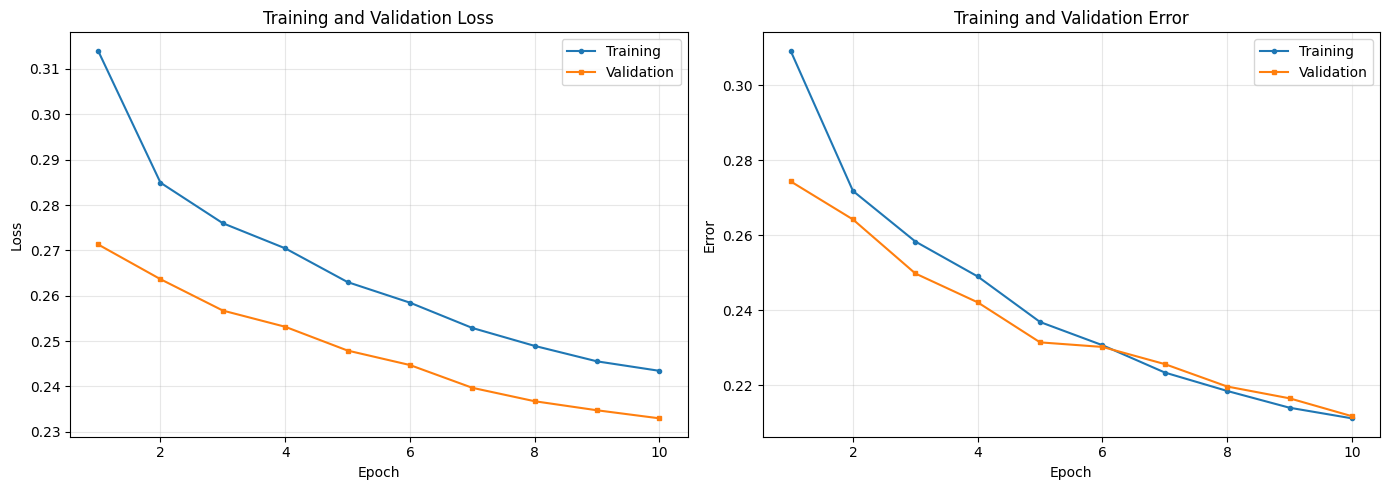

Epoch  11/30 | LR: 0.001 | Train Loss: 0.2419 (F:0.111 T:0.000 O:0.264 H:-0.024) | Val Loss: 0.2305 | Train Err: 0.2093 | Val Err: 0.2100
Epoch  12/30 | LR: 0.001 | Train Loss: 0.2403 (F:0.110 T:0.000 O:0.262 H:-0.024) | Val Loss: 0.2355 | Train Err: 0.2071 | Val Err: 0.2240
Epoch  13/30 | LR: 0.001 | Train Loss: 0.2395 (F:0.110 T:0.000 O:0.261 H:-0.024) | Val Loss: 0.2308 | Train Err: 0.2062 | Val Err: 0.2074
Epoch  14/30 | LR: 0.001 | Train Loss: 0.2390 (F:0.110 T:0.000 O:0.261 H:-0.023) | Val Loss: 0.2301 | Train Err: 0.2055 | Val Err: 0.2124
Epoch  15/30 | LR: 0.001 | Train Loss: 0.2382 (F:0.109 T:0.000 O:0.260 H:-0.023) | Val Loss: 0.2277 | Train Err: 0.2047 | Val Err: 0.2069
Epoch  16/30 | LR: 0.001 | Train Loss: 0.2381 (F:0.109 T:0.000 O:0.260 H:-0.023) | Val Loss: 0.2315 | Train Err: 0.2044 | Val Err: 0.2125
Epoch  17/30 | LR: 0.001 | Train Loss: 0.2373 (F:0.109 T:0.000 O:0.259 H:-0.023) | Val Loss: 0.2275 | Train Err: 0.2034 | Val Err: 0.2077
Epoch  18/30 | LR: 0.001 | Train L

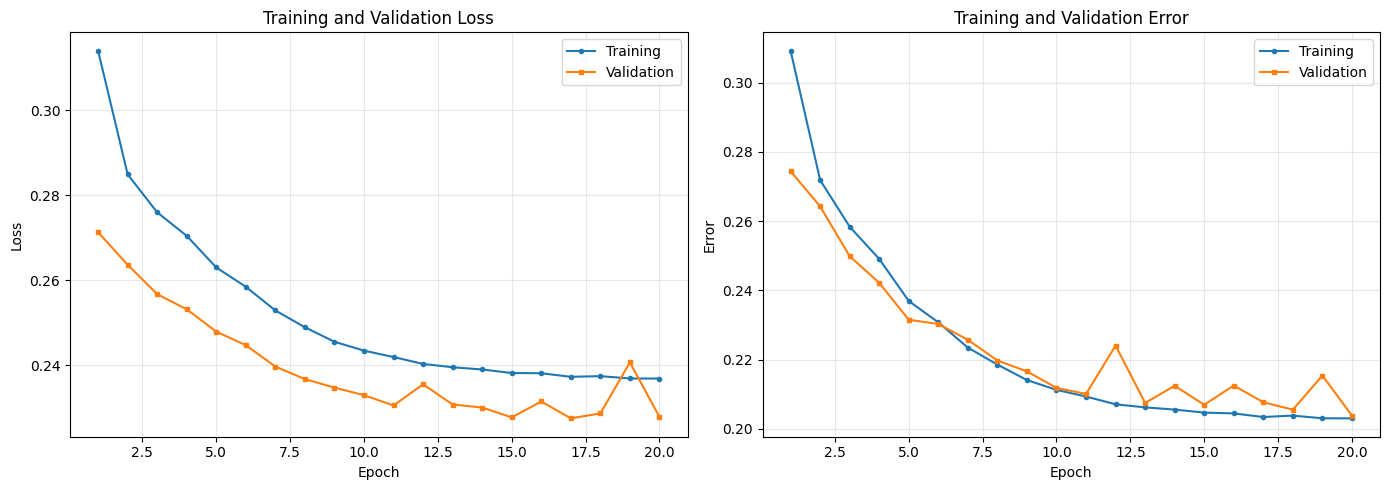

Epoch  21/30 | LR: 0.001 | Train Loss: 0.2367 (F:0.109 T:0.000 O:0.258 H:-0.023) | Val Loss: 0.2285 | Train Err: 0.2027 | Val Err: 0.2094
Epoch  22/30 | LR: 0.001 | Train Loss: 0.2363 (F:0.109 T:0.000 O:0.258 H:-0.023) | Val Loss: 0.2292 | Train Err: 0.2023 | Val Err: 0.2061
Epoch  23/30 | LR: 0.001 | Train Loss: 0.2361 (F:0.108 T:0.000 O:0.258 H:-0.023) | Val Loss: 0.2280 | Train Err: 0.2019 | Val Err: 0.2048
Epoch  24/30 | LR: 0.001 | Train Loss: 0.2362 (F:0.108 T:0.000 O:0.258 H:-0.023) | Val Loss: 0.2294 | Train Err: 0.2020 | Val Err: 0.2119
Epoch  25/30 | LR: 0.001 | Train Loss: 0.2360 (F:0.108 T:0.000 O:0.257 H:-0.023) | Val Loss: 0.2266 | Train Err: 0.2019 | Val Err: 0.2056
Epoch  26/30 | LR: 0.001 | Train Loss: 0.2355 (F:0.108 T:0.000 O:0.257 H:-0.023) | Val Loss: 0.2323 | Train Err: 0.2014 | Val Err: 0.2083
Epoch  27/30 | LR: 0.001 | Train Loss: 0.2355 (F:0.108 T:0.000 O:0.257 H:-0.023) | Val Loss: 0.2301 | Train Err: 0.2010 | Val Err: 0.2114
Epoch  28/30 | LR: 0.001 | Train L

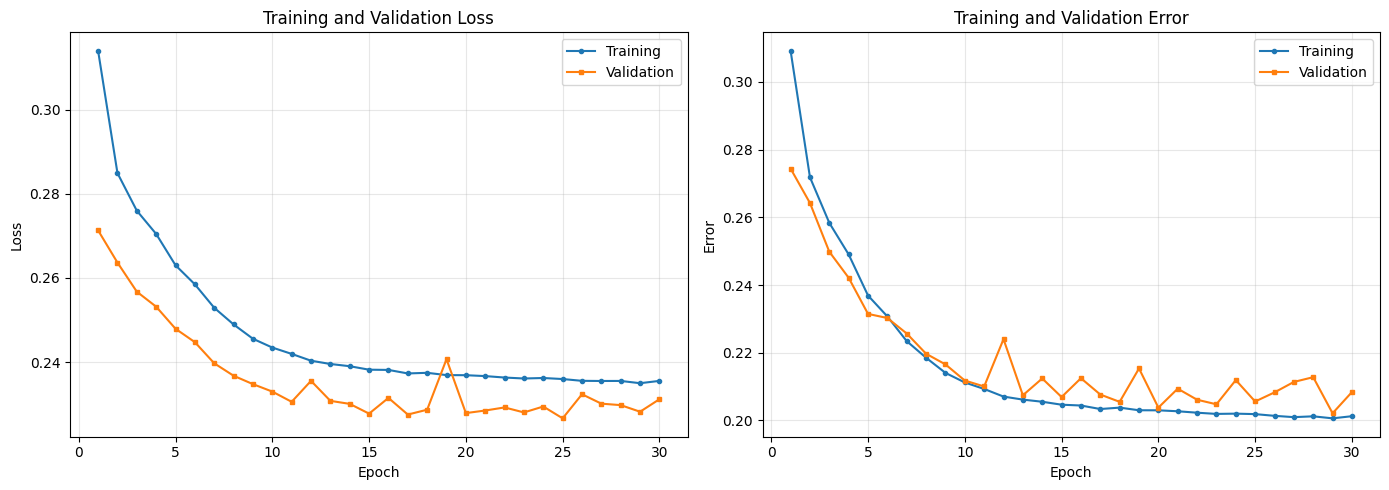

Enhanced musical training completed!
Training ended at: 2025-08-14 22:26:03
Total training duration: 0:39:55.929254
Final enhanced model saved to /content/drive/MyDrive/APS360_Team_2_Project/models/model_musical_model_epochs30_lr0.001_wd0.0001_dropconv0.2_droplstm0.3_dropfc0.4_start20250814_214607_end20250814_222603_FINAL.pth

ENHANCED MUSICAL TRAINING COMPLETE!
Training stopped at epoch: None
Best validation loss: 0.226619
Final model saved to: /content/drive/MyDrive/APS360_Team_2_Project/models/model_musical_model_epochs30_lr0.001_wd0.0001_dropconv0.2_droplstm0.3_dropfc0.4_start20250814_214607_end20250814_222603_FINAL.pth


In [ ]:
## Train Model with Enhanced Musical Loss

# Create a fresh model for musical training
musical_model = CRNN_OnsetsAndFrames(
    dropout_conv=0.2,
    dropout_lstm=0.3,
    dropout_fc=0.4
).to(DEVICE)

print(f"Created fresh model with {sum(p.numel() for p in musical_model.parameters())} parameters")

# Train with the enhanced musical loss
print("Starting training with enhanced musical loss...")
print("This should produce more musical-sounding outputs!")

results = train_with_musical_loss(
    model=musical_model,
    train_loader=train_loader,
    val_loader=val_loader,
    musical_criterion=musical_criterion,
    num_epochs=30,
    save_path="enhanced_musical_training",
    lr=1e-3,
    lr_policy="plateau",
    weight_decay=1e-4,
    early_stopping_patience=15,
    grad_clip=1.0
)

print("\n" + "="*60)
print("ENHANCED MUSICAL TRAINING COMPLETE!")
print("="*60)
print(f"Training stopped at epoch: {results.get('early_stop_epoch', 'Not triggered')}")
print(f"Best validation loss: {results['best_val_loss']:.6f}")
print(f"Final model saved to: {results['final_model_path']}")

# The model should now better understand musical structure and produce
# more coherent, musical-sounding piano transcriptions!


In [ ]:
## Compare Original vs Enhanced Musical Models

def compare_models_musical_quality(original_model, enhanced_model, test_loader, sample_idx=0,
                                 output_dir="/content/drive/My Drive/APS360_Team_2_Project/results/comparison"):
    """
    Compare the musical quality of original vs enhanced models.
    Tests with multiple thresholds and generates audio for both.
    """
    import os
    from pathlib import Path

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    device = next(original_model.parameters()).device

    # Get a test batch
    original_model.eval()
    enhanced_model.eval()

    with torch.no_grad():
        batch = next(iter(test_loader))
        audio = batch["audio"].to(device)[:1]  # Take just one sample
        target = batch["piano_roll"].to(device)[:1]

        print(f"Comparing models on test sample...")
        print(f"Audio shape: {audio.shape}")
        print(f"Target shape: {target.shape}")

        # Prepare audio for models
        audio_model = audio.transpose(1, 2)  # [1, 128, T]
        target_aligned = target.permute(0, 2, 1).contiguous()  # [1, 88, T]

        # Get predictions from both models
        original_logits = original_model(audio_model)
        enhanced_logits = enhanced_model(audio_model)

        # Ensure same time dimensions
        min_time = min(original_logits.shape[2], enhanced_logits.shape[2], target_aligned.shape[2])
        original_logits = original_logits[:, :, :min_time]
        enhanced_logits = enhanced_logits[:, :, :min_time]
        target_aligned = target_aligned[:, :, :min_time]

        # Convert to probabilities
        original_probs = torch.sigmoid(original_logits)[0].cpu().numpy()  # [88, T]
        enhanced_probs = torch.sigmoid(enhanced_logits)[0].cpu().numpy()  # [88, T]
        true_labels = target_aligned[0].cpu().numpy()  # [88, T]

        print(f"Prediction shapes: {original_probs.shape}")
        print(f"Time frames: {min_time}")

        # Calculate statistics
        true_sparsity = (true_labels > 0.5).mean()
        orig_sparsity_03 = (original_probs > 0.3).mean()
        enh_sparsity_03 = (enhanced_probs > 0.3).mean()
        orig_sparsity_05 = (original_probs > 0.5).mean()
        enh_sparsity_05 = (enhanced_probs > 0.5).mean()

        print(f"\nSparsity Analysis (fraction of active notes):")
        print(f"  True labels: {true_sparsity:.4f}")
        print(f"  Original model (0.3 thresh): {orig_sparsity_03:.4f}")
        print(f"  Enhanced model (0.3 thresh): {enh_sparsity_03:.4f}")
        print(f"  Original model (0.5 thresh): {orig_sparsity_05:.4f}")
        print(f"  Enhanced model (0.5 thresh): {enh_sparsity_05:.4f}")

        # Calculate temporal consistency (how much the predictions change frame-to-frame)
        orig_temporal_var = np.mean(np.var(np.diff(original_probs, axis=1), axis=1))
        enh_temporal_var = np.mean(np.var(np.diff(enhanced_probs, axis=1), axis=1))
        true_temporal_var = np.mean(np.var(np.diff(true_labels, axis=1), axis=1))

        print(f"\nTemporal Consistency (lower = smoother):")
        print(f"  True labels: {true_temporal_var:.6f}")
        print(f"  Original model: {orig_temporal_var:.6f}")
        print(f"  Enhanced model: {enh_temporal_var:.6f}")

        # Frame rate for MIDI conversion
        fs = SAMPLE_RATE / HOP_LENGTH

        # Generate MIDI files for comparison
        comparison_files = {}

        # True labels
        true_midi = output_dir / "comparison_TRUE_LABELS.mid"
        true_mp3 = output_dir / "comparison_TRUE_LABELS.mp3"
        save_midi_from_piano_roll(true_labels, fs=fs, output_path=true_midi, threshold=0.5)
        true_audio = midi_to_mp3(true_midi, true_mp3)
        comparison_files['true'] = {'midi': true_midi, 'mp3': true_mp3, 'audio': true_audio}

        # Original model predictions
        orig_midi_03 = output_dir / "comparison_ORIGINAL_MODEL_thresh_0.3.mid"
        orig_mp3_03 = output_dir / "comparison_ORIGINAL_MODEL_thresh_0.3.mp3"
        save_midi_from_piano_roll(original_probs, fs=fs, output_path=orig_midi_03, threshold=0.3)
        orig_audio_03 = midi_to_mp3(orig_midi_03, orig_mp3_03)
        comparison_files['original_03'] = {'midi': orig_midi_03, 'mp3': orig_mp3_03, 'audio': orig_audio_03}

        orig_midi_05 = output_dir / "comparison_ORIGINAL_MODEL_thresh_0.5.mid"
        orig_mp3_05 = output_dir / "comparison_ORIGINAL_MODEL_thresh_0.5.mp3"
        save_midi_from_piano_roll(original_probs, fs=fs, output_path=orig_midi_05, threshold=0.5)
        orig_audio_05 = midi_to_mp3(orig_midi_05, orig_mp3_05)
        comparison_files['original_05'] = {'midi': orig_midi_05, 'mp3': orig_mp3_05, 'audio': orig_audio_05}

        # Enhanced model predictions
        enh_midi_03 = output_dir / "comparison_ENHANCED_MODEL_thresh_0.3.mid"
        enh_mp3_03 = output_dir / "comparison_ENHANCED_MODEL_thresh_0.3.mp3"
        save_midi_from_piano_roll(enhanced_probs, fs=fs, output_path=enh_midi_03, threshold=0.3)
        enh_audio_03 = midi_to_mp3(enh_midi_03, enh_mp3_03)
        comparison_files['enhanced_03'] = {'midi': enh_midi_03, 'mp3': enh_mp3_03, 'audio': enh_audio_03}

        enh_midi_05 = output_dir / "comparison_ENHANCED_MODEL_thresh_0.5.mid"
        enh_mp3_05 = output_dir / "comparison_ENHANCED_MODEL_thresh_0.5.mp3"
        save_midi_from_piano_roll(enhanced_probs, fs=fs, output_path=enh_midi_05, threshold=0.5)
        enh_audio_05 = midi_to_mp3(enh_midi_05, enh_mp3_05)
        comparison_files['enhanced_05'] = {'midi': enh_midi_05, 'mp3': enh_mp3_05, 'audio': enh_audio_05}

        print(f"\nMIDI and MP3 files generated in: {output_dir}")

        # Display audio comparison
        print("\n" + "="*70)
        print("🎵 AUDIO COMPARISON - Listen to the difference!")
        print("="*70)

        print("\n🎹 TRUE LABELS (Ground Truth):")
        if true_audio is not None:
            display(Audio(true_audio, rate=44100))

        print("\n🔴 ORIGINAL MODEL (Threshold 0.3):")
        if orig_audio_03 is not None:
            display(Audio(orig_audio_03, rate=44100))

        print("\n🔴 ORIGINAL MODEL (Threshold 0.5):")
        if orig_audio_05 is not None:
            display(Audio(orig_audio_05, rate=44100))

        print("\n🟢 ENHANCED MUSICAL MODEL (Threshold 0.3):")
        if enh_audio_03 is not None:
            display(Audio(enh_audio_03, rate=44100))

        print("\n🟢 ENHANCED MUSICAL MODEL (Threshold 0.5):")
        if enh_audio_05 is not None:
            display(Audio(enh_audio_05, rate=44100))

        print("\n" + "="*70)
        print("💡 Listen for:")
        print("- More stable, less flickering notes in enhanced model")
        print("- Better harmonic relationships (chords that sound good together)")
        print("- Clearer note onsets in enhanced model")
        print("- Overall more musical and coherent sound")
        print("="*70)

        return {
            'statistics': {
                'true_sparsity': true_sparsity,
                'original_sparsity_03': orig_sparsity_03,
                'enhanced_sparsity_03': enh_sparsity_03,
                'original_sparsity_05': orig_sparsity_05,
                'enhanced_sparsity_05': enh_sparsity_05,
                'true_temporal_var': true_temporal_var,
                'original_temporal_var': orig_temporal_var,
                'enhanced_temporal_var': enh_temporal_var
            },
            'files': comparison_files,
            'predictions': {
                'true_labels': true_labels,
                'original_probs': original_probs,
                'enhanced_probs': enhanced_probs
            }
        }

print("Musical quality comparison function created!")
print("This will help you hear the difference between the old and new models.")


Musical quality comparison function created!
This will help you hear the difference between the old and new models.


12. test overfitting model, obtain output as a midi and the true label from overfitted dataset

In [ ]:
# Install and import dependencies
!pip install pretty_midi soundfile pydub

import os
import torch
import numpy as np
import pretty_midi
import soundfile as sf
from pathlib import Path
from IPython.display import Audio, display
from pydub import AudioSegment
from pydub.playback import play

def save_midi_from_piano_roll(piano_roll: np.ndarray,
                              fs: float,
                              output_path: Path,
                              threshold: float = 0.5):
    """
    Convert a piano-roll (88 × T) array into a MIDI file.
    fs is frames-per-second of the piano roll (can be float, e.g., 31.25).
    """
    # Binarize
    binary_roll = (piano_roll > threshold).astype(float)

    pm = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)

    for note_idx in range(88):
        row = binary_roll[note_idx]
        # Pad so diff picks up first/last notes
        padded = np.pad(row, (1, 1), 'constant')
        diff = np.diff(padded)
        onsets  = np.where(diff == 1)[0]
        offsets = np.where(diff == -1)[0] - 1

        for start, end in zip(onsets, offsets):
            start_time = start / fs
            end_time   = end   / fs
            note = pretty_midi.Note(
                velocity=100,
                pitch=note_idx + 21,  # MIDI range 21–108
                start=start_time,
                end=end_time
            )
            piano.notes.append(note)

    pm.instruments.append(piano)
    pm.write(str(output_path))
    return pm

def midi_to_mp3(midi_path: Path, mp3_path: Path, sample_rate: int = 44100):
    """
    Convert MIDI file to MP3 using pretty_midi synthesizer.
    """
    try:
        # Load MIDI file
        midi_data = pretty_midi.PrettyMIDI(str(midi_path))

        # Synthesize audio
        audio_data = midi_data.synthesize(fs=sample_rate)

        # Save as temporary WAV file
        temp_wav_path = mp3_path.with_suffix('.wav')
        sf.write(str(temp_wav_path), audio_data, sample_rate)

        # Convert WAV to MP3 using pydub
        audio_segment = AudioSegment.from_wav(str(temp_wav_path))
        audio_segment.export(str(mp3_path), format="mp3", bitrate="192k")

        # Clean up temporary WAV file
        temp_wav_path.unlink()

        return audio_data

    except Exception as e:
        print(f"Error converting {midi_path} to MP3: {e}")
        return None

def get_model_name(model):
    """
    Extract model name from model object or class name.
    """
    if hasattr(model, '__class__'):
        return model.__class__.__name__
    else:
        return "UnknownModel"

path = "/content/drive/My Drive/APS360_Team_2_Project/results/train_tests"

def generate_midi_comparison_from_overfit_dataset(model, overfit_loader, sample_idx=0,
                                                 output_dir=path,
                                                 fs=None):

    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Get model name for file naming
    model_name = get_model_name(model)

    # Determine correct frame rate if not provided
    if fs is None:
        # Use the same FPS as used to create features/labels
        try:
            fs = float(SAMPLE_RATE) / float(HOP_LENGTH)
        except NameError:
            fs = 100.0  # fallback

    # Get device
    device = next(model.parameters()).device

    # Get a batch from the overfit loader
    model.eval()
    with torch.no_grad():
        batch = next(iter(overfit_loader))

        # Move to device
        audio = batch["audio"].to(device)            # [B, T, 128]
        target = batch["piano_roll"].to(device)      # [B, T, 88]

        print(f"Batch shapes:")
        print(f"  Audio: {audio.shape}")
        print(f"  Target: {target.shape}")
        print(f"  Model: {model_name}")

        # Prepare audio for model: [B, T, 128] -> [B, 128, T]
        audio_model = audio.transpose(1, 2)

        # Get model predictions
        logits = model(audio_model)                  # [B, 88, T]

        # Convert to probabilities
        probs = torch.sigmoid(logits)               # [B, 88, T]

        # Align target to [B, 88, T] BEFORE computing min_time
        target_aligned = target.permute(0, 2, 1).contiguous()    # [B, 88, T]

        # Ensure matching time dimensions (crop along time axis)
        min_time = min(probs.shape[2], target_aligned.shape[2])
        if probs.shape[2] != min_time:
            probs = probs[:, :, :min_time]
        if target_aligned.shape[2] != min_time:
            target_aligned = target_aligned[:, :, :min_time]

        # Extract single sample
        if sample_idx >= audio.shape[0]:
            print(f"Warning: sample_idx {sample_idx} >= batch_size {audio.shape[0]}, using sample 0")
            sample_idx = 0

        # Get the specific sample: [88, T]
        true_piano_roll = target_aligned[sample_idx].cpu().numpy()      # [88, T]
        pred_piano_roll = probs[sample_idx].cpu().numpy()               # [88, T]

        print(f"Sample shapes:")
        print(f"  True piano roll: {true_piano_roll.shape}")
        print(f"  Predicted piano roll: {pred_piano_roll.shape}")
        print(f"  Using fs={fs:.4f} frames/sec for MIDI conversion")
        print(f"  True label range: [{true_piano_roll.min():.3f}, {true_piano_roll.max():.3f}]")
        print(f"  Prediction range: [{pred_piano_roll.min():.3f}, {pred_piano_roll.max():.3f}]")

        # Calculate some statistics
        true_sparsity = (true_piano_roll > 0.5).mean()
        pred_sparsity_05 = (pred_piano_roll > 0.5).mean()
        pred_sparsity_01 = (pred_piano_roll > 0.1).mean()

        print(f"  True label sparsity: {true_sparsity:.4f}")
        print(f"  Predicted sparsity (>0.5): {pred_sparsity_05:.4f}")
        print(f"  Predicted sparsity (>0.1): {pred_sparsity_01:.4f}")

        # Define file paths with model name and sample number
        base_name = f"{model_name}_sample_{sample_idx}"

        # Save true labels as MIDI and MP3
        true_midi_path = output_dir / f"{base_name}_TRUE_LABELS.mid"
        true_mp3_path = output_dir / f"{base_name}_TRUE_LABELS.mp3"

        save_midi_from_piano_roll(true_piano_roll, fs=fs, output_path=true_midi_path, threshold=0.5)
        true_audio = midi_to_mp3(true_midi_path, true_mp3_path)
        print(f"Saved true labels - MIDI: {true_midi_path}")
        print(f"Saved true labels - MP3: {true_mp3_path}")

        # Save predictions as MIDI and MP3 (threshold 0.5)
        pred_midi_path_05 = output_dir / f"{base_name}_PREDICTIONS_threshold_0.5.mid"
        pred_mp3_path_05 = output_dir / f"{base_name}_PREDICTIONS_threshold_0.5.mp3"

        save_midi_from_piano_roll(pred_piano_roll, fs=fs, output_path=pred_midi_path_05, threshold=0.5)
        pred_audio_05 = midi_to_mp3(pred_midi_path_05, pred_mp3_path_05)
        print(f"Saved predictions (0.5) - MIDI: {pred_midi_path_05}")
        print(f"Saved predictions (0.5) - MP3: {pred_mp3_path_05}")

        # Save predictions as MIDI and MP3 (lower threshold for more notes)
        pred_midi_path_01 = output_dir / f"{base_name}_PREDICTIONS_threshold_0.1.mid"
        pred_mp3_path_01 = output_dir / f"{base_name}_PREDICTIONS_threshold_0.1.mp3"

        save_midi_from_piano_roll(pred_piano_roll, fs=fs, output_path=pred_midi_path_01, threshold=0.1)
        pred_audio_01 = midi_to_mp3(pred_midi_path_01, pred_mp3_path_01)
        print(f"Saved predictions (0.1) - MIDI: {pred_midi_path_01}")
        print(f"Saved predictions (0.1) - MP3: {pred_mp3_path_01}")

        # Save raw numpy arrays for debugging
        np.save(output_dir / f"{base_name}_true_piano_roll.npy", true_piano_roll)
        np.save(output_dir / f"{base_name}_pred_piano_roll.npy", pred_piano_roll)
        print(f"Saved raw arrays to {output_dir}")

        # Display audio in Google Colab cell output
        print("\n" + "="*50)
        print("AUDIO PLAYBACK IN COLAB:")
        print("="*50)

        if true_audio is not None:
            print("\n🎵 TRUE LABELS AUDIO:")
            display(Audio(true_audio, rate=44100))

        if pred_audio_05 is not None:
            print("\n🎵 PREDICTIONS AUDIO (Threshold 0.5):")
            display(Audio(pred_audio_05, rate=44100))

        if pred_audio_01 is not None:
            print("\n🎵 PREDICTIONS AUDIO (Threshold 0.1):")
            display(Audio(pred_audio_01, rate=44100))

        return {
            'true_piano_roll': true_piano_roll,
            'pred_piano_roll': pred_piano_roll,
            'true_midi_path': true_midi_path,
            'true_mp3_path': true_mp3_path,
            'pred_midi_path_05': pred_midi_path_05,
            'pred_mp3_path_05': pred_mp3_path_05,
            'pred_midi_path_01': pred_midi_path_01,
            'pred_mp3_path_01': pred_mp3_path_01,
            'audio_data': {
                'true_audio': true_audio,
                'pred_audio_05': pred_audio_05,
                'pred_audio_01': pred_audio_01
            },
            'statistics': {
                'true_sparsity': true_sparsity,
                'pred_sparsity_05': pred_sparsity_05,
                'pred_sparsity_01': pred_sparsity_01
            },
            'label': target_aligned,
            'model_name': model_name
        }


# === USAGE: Generate MIDI and MP3 comparison from overfit dataset ===

# Make sure model is trained first!
# Assuming you have: model, overfit_loader from previous steps

print("Generating MIDI and MP3 comparison from overfit dataset...")

# Generate comparison for the specified sample in the batch
results = generate_midi_comparison_from_overfit_dataset(
    model=musical_model,
    overfit_loader=val_loader,
    sample_idx=10,  # Use x'th sample
    output_dir=path
)

print("\nComparison complete!")
print(f"Model: {results['model_name']}")
print(f"Files saved to Google Drive:")
print(f"  True labels MIDI: {results['true_midi_path']}")
print(f"  True labels MP3: {results['true_mp3_path']}")
print(f"  Predictions MIDI (0.5): {results['pred_midi_path_05']}")
print(f"  Predictions MP3 (0.5): {results['pred_mp3_path_05']}")
print(f"  Predictions MIDI (0.1): {results['pred_midi_path_01']}")
print(f"  Predictions MP3 (0.1): {results['pred_mp3_path_01']}")
print(f"\nAudio files are also playing above in the cell output!")

Generating MIDI and MP3 comparison from overfit dataset...
Batch shapes:
  Audio: torch.Size([64, 312, 128])
  Target: torch.Size([64, 312, 88])
  Model: CRNN_OnsetsAndFrames
Sample shapes:
  True piano roll: (88, 312)
  Predicted piano roll: (88, 312)
  Using fs=31.2500 frames/sec for MIDI conversion
  True label range: [0.000, 1.000]
  Prediction range: [0.000, 0.698]
  True label sparsity: 0.1292
  Predicted sparsity (>0.5): 0.1353
  Predicted sparsity (>0.1): 0.5482
Saved true labels - MIDI: /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_10_TRUE_LABELS.mid
Saved true labels - MP3: /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_10_TRUE_LABELS.mp3
Saved predictions (0.5) - MIDI: /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_10_PREDICTIONS_threshold_0.5.mid
Saved predictions (0.5) - MP3: /content/drive/My Drive/APS360_Team_2_Project/results/trai


🎵 PREDICTIONS AUDIO (Threshold 0.5):



🎵 PREDICTIONS AUDIO (Threshold 0.1):



Comparison complete!
Model: CRNN_OnsetsAndFrames
Files saved to Google Drive:
  True labels MIDI: /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_10_TRUE_LABELS.mid
  True labels MP3: /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_10_TRUE_LABELS.mp3
  Predictions MIDI (0.5): /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_10_PREDICTIONS_threshold_0.5.mid
  Predictions MP3 (0.5): /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_10_PREDICTIONS_threshold_0.5.mp3
  Predictions MIDI (0.1): /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_10_PREDICTIONS_threshold_0.1.mid
  Predictions MP3 (0.1): /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_10_PREDICTIONS_threshold_0.1.mp3

Audio files are also playing above in the cel

In [ ]:
# def test_original_audio_file(split_name='train', sample_idx=0, cache_dir=None):
#       """Load and play original audio file"""
#       if cache_dir is None:
#           cache_dir = directories['data_cached']

#       # Load metadata
#       cache_paths = get_cache_paths(split_name, cache_dir)
#       with open(cache_paths['metadata'], 'r') as f:
#           metadata_list = json.load(f)

#       # Get original file path
#       sample_metadata = metadata_list[sample_idx]['metadata']
#       audio_path = Path(sample_metadata['audio_path'])

#       print(f"Loading original audio: {audio_path.name}")
#       print(f"Title: {sample_metadata['title']}")
#       print(f"Composer: {sample_metadata['composer']}")

#       # Load original audio
#       audio, sr = librosa.load(audio_path, sr=SAMPLE_RATE, mono=True)

#       # Get the specific window timing
#       window_start_time = metadata_list[sample_idx]['window_start_time']
#       window_duration = WINDOW_SIZE_SECONDS

#       start_sample = int(window_start_time * SAMPLE_RATE)
#       end_sample = start_sample + int(window_duration * SAMPLE_RATE)

#       # Extract the exact window
#       audio_window = audio[start_sample:end_sample]

#       print(f"Window start time: {window_start_time:.2f}s")
#       print(f"Window duration: {len(audio_window) / SAMPLE_RATE:.2f}s")

#       # Save and play
#       output_path = f"/content/originalsample{sample_idx}.wav"
#       sf.write(output_path, audio_window, SAMPLE_RATE)

#       return Audio(audio_window, rate=SAMPLE_RATE)

# # Usage:
# original_audio = test_original_audio_file(split_name='train', sample_idx=0)
# original_audio

In [ ]:

# def reconstruct_audio_from_mel(mel_spectrogram_norm, sr=16000, n_fft=2048, hop_length=512):
#     """
#     Reconstruct audio from normalized mel spectrogram
#     mel_spectrogram_norm: (T, 128) - your cached format
#     """
#     # Transpose back to librosa format (128, T)
#     mel_spec_norm = mel_spectrogram_norm.T

#     # Denormalize (reverse the normalization in extract_audio_features)
#     # Note: This is approximate since we lost the original mean/std
#     mel_spec_db = mel_spec_norm * 40.0  # Rough estimate for std

#     # Convert back to power spectrogram
#     mel_spec_power = librosa.db_to_power(mel_spec_db)

#     # Use Griffin-Lim to reconstruct audio
#     audio_reconstructed = librosa.feature.inverse.mel_to_audio(
#         mel_spec_power,
#         sr=sr,
#         n_fft=n_fft,
#         hop_length=hop_length,
#         n_iter=32  # More iterations = better quality
#     )

#     return audio_reconstructed

# def test_cached_audio_sample(split_name='train', sample_idx=0, cache_dir=None):
#     """Load and play audio from cached data"""
#     if cache_dir is None:
#         cache_dir = directories['data_cached']  # Use your global cache directory

#     # Load cached audio features
#     cache_paths = get_cache_paths(split_name, cache_dir)
#     audio_features = np.load(cache_paths['audio'])  # Shape: (N, T, 128)

#     # Load metadata for context
#     with open(cache_paths['metadata'], 'r') as f:
#         metadata_list = json.load(f)

#     print(f"Loaded {len(audio_features)} cached samples")
#     print(f"Sample {sample_idx} metadata: {metadata_list[sample_idx]['metadata']['title']}")

#     # Get specific sample
#     mel_spec = audio_features[sample_idx]  # Shape: (T, 128)
#     print(f"Mel spectrogram shape: {mel_spec.shape}")

#     # Reconstruct audio
#     reconstructed_audio = reconstruct_audio_from_mel(mel_spec)

#     # Save and display
#     output_path = f"/content/reconstructed_sample_{sample_idx}.wav"
#     sf.write(output_path, reconstructed_audio, SAMPLE_RATE)

#     print(f"Reconstructed audio saved to: {output_path}")
#     print(f"Audio duration: {len(reconstructed_audio) / SAMPLE_RATE:.2f} seconds")

#     # Play in Colab
#     return Audio(reconstructed_audio, rate=SAMPLE_RATE)

# # Usage:
# audio_player = test_cached_audio_sample(split_name='train', sample_idx=0)
# audio_player  # This will create an audio player in Colab

In [ ]:
# def reconstruct_audio_from_mel(mel_spectrogram_norm: np.ndarray,
#                                sr: int = 16000,
#                                n_fft: int = 2048,
#                                hop_length: int = 512) -> np.ndarray:
#     """
#     Approximate reconstruction of audio from a normalized mel spectrogram.
#     Input mel_spectrogram_norm is shaped (T, 128) as cached in this notebook.

#     Since the original per-sample mean/std in dB were discarded during normalization,
#     we map the normalized values to a plausible dB range via robust min-max scaling.
#     This is sufficient for an audible sanity check of the training data.
#     """
#     # To librosa format: (128, T)
#     mel_norm = mel_spectrogram_norm.T

#     # Robust min-max to dB in [-80, 0]
#     lo = np.percentile(mel_norm, 1)
#     hi = np.percentile(mel_norm, 99)
#     mel_scaled = (mel_norm - lo) / (hi - lo + 1e-8)
#     mel_scaled = np.clip(mel_scaled, 0.0, 1.0)
#     mel_db = mel_scaled * 80.0 - 80.0

#     # dB -> power
#     mel_power = librosa.db_to_power(mel_db)

#     # Griffin-Lim inversion
#     audio = librosa.feature.inverse.mel_to_audio(
#         mel_power,
#         sr=sr,
#         n_fft=n_fft,
#         hop_length=hop_length,
#         n_iter=64,
#     )
#     return audio


# def play_cached_audio_sample(split_name: str = 'train', sample_idx: int = 0, cache_dir: Path = None):
#     """
#     Load a cached mel-spectrogram window, print quick sanity stats, reconstruct
#     approximate audio, and play it.
#     """
#     if cache_dir is None:
#         cache_dir = directories['data_cached']

#     cache_paths = get_cache_paths(split_name, cache_dir)

#     audio_features = np.load(cache_paths['audio'], mmap_mode='r')      # (N, T, 128)
#     piano_rolls    = np.load(cache_paths['piano_roll'], mmap_mode='r') # (N, T, 88)

#     with open(cache_paths['metadata'], 'r') as f:
#         metadata_list = json.load(f)

#     assert len(audio_features) == len(piano_rolls) == len(metadata_list), "Cache arrays/metadata length mismatch"

#     mel_spec = audio_features[sample_idx]
#     piano    = piano_rolls[sample_idx]

#     print(f"Cached windows: {len(audio_features):,}")
#     print(f"Sample index: {sample_idx}")
#     print(f"Mel shape (T, 128): {mel_spec.shape}")
#     print(f"Piano-roll shape (T, 88): {piano.shape}")
#     print(f"Frames match: {mel_spec.shape[0] == piano.shape[0]}")
#     print(f"Piano-roll sparsity (mean >0): {piano.mean():.4f}")

#     audio = reconstruct_audio_from_mel(mel_spec, sr=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH)

#     # Optional: save to file (useful in Colab)
#     out_path = f"/content/reconstructed_sample_{sample_idx}.wav"
#     try:
#         sf.write(out_path, audio, SAMPLE_RATE)
#         print(f"Saved reconstructed audio to: {out_path}")
#     except Exception as e:
#         print(f"Could not save WAV: {e}")

#     display(Audio(audio, rate=SAMPLE_RATE))
#     return audio


# def play_original_window_from_cache(split_name: str = 'train', sample_idx: int = 0, cache_dir: Path = None):
#     """
#     Play the exact 10s window from the original audio file using metadata
#     offset/duration, without loading the whole file.
#     """
#     if cache_dir is None:
#         cache_dir = directories['data_cached']

#     cache_paths = get_cache_paths(split_name, cache_dir)
#     with open(cache_paths['metadata'], 'r') as f:
#         metadata_list = json.load(f)

#     entry = metadata_list[sample_idx]
#     meta = entry['metadata']
#     audio_path = Path(meta['audio_path'])
#     start_time = float(entry['window_start_time'])

#     print(f"Original file: {audio_path.name}")
#     print(f"Title: {meta['title']} | Composer: {meta['composer']}")
#     print(f"Window start: {start_time:.2f}s | Duration: {WINDOW_SIZE_SECONDS:.2f}s")

#     # Fast partial load
#     audio, _ = librosa.load(
#         audio_path,
#         sr=SAMPLE_RATE,
#         mono=True,
#         offset=start_time,
#         duration=WINDOW_SIZE_SECONDS,
#     )

#     # Optional: save
#     out_path = f"/content/original_window_{sample_idx}.wav"
#     try:
#         sf.write(out_path, audio, SAMPLE_RATE)
#         print(f"Saved original window to: {out_path}")
#     except Exception as e:
#         print(f"Could not save WAV: {e}")

#     display(Audio(audio, rate=SAMPLE_RATE))
#     return audio

# # Demo: hear both the cached (reconstructed) and the original window for comparison
# _ = play_cached_audio_sample(split_name='train', sample_idx=55)
# _ = play_original_window_from_cache(split_name='train', sample_idx=55)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_loaded_from_drive = CRNN_OnsetsAndFrames().to(device)

state = torch.load('/content/drive/MyDrive/APS360_Team_2_Project/models/model_training_model_epochs59_lr0.001_wd0.0001_dropconv0.2_droplstm0.3_dropfc0.4_start20250814_173516_endongoing_epoch059.pth', map_location=torch.device('cpu'))
model_loaded_from_drive.load_state_dict(state['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Install and import dependencies
!pip install pretty_midi soundfile pydub

import os
import torch
import numpy as np
import pretty_midi
import soundfile as sf
from pathlib import Path
from IPython.display import Audio, display
from pydub import AudioSegment
from pydub.playback import play

def save_midi_from_piano_roll(piano_roll: np.ndarray,
                              fs: float,
                              output_path: Path,
                              threshold: float = 0.5):
    """
    Convert a piano-roll (88 × T) array into a MIDI file.
    fs is frames-per-second of the piano roll (can be float, e.g., 31.25).
    """
    # Binarize
    binary_roll = (piano_roll > threshold).astype(float)

    pm = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)

    for note_idx in range(88):
        row = binary_roll[note_idx]
        # Pad so diff picks up first/last notes
        padded = np.pad(row, (1, 1), 'constant')
        diff = np.diff(padded)
        onsets  = np.where(diff == 1)[0]
        offsets = np.where(diff == -1)[0] - 1

        for start, end in zip(onsets, offsets):
            start_time = start / fs
            end_time   = end   / fs
            note = pretty_midi.Note(
                velocity=100,
                pitch=note_idx + 21,  # MIDI range 21–108
                start=start_time,
                end=end_time
            )
            piano.notes.append(note)

    pm.instruments.append(piano)
    pm.write(str(output_path))
    return pm

def midi_to_mp3(midi_path: Path, mp3_path: Path, sample_rate: int = 44100):
    """
    Convert MIDI file to MP3 using pretty_midi synthesizer.
    """
    try:
        # Load MIDI file
        midi_data = pretty_midi.PrettyMIDI(str(midi_path))

        # Synthesize audio
        audio_data = midi_data.synthesize(fs=sample_rate)

        # Save as temporary WAV file
        temp_wav_path = mp3_path.with_suffix('.wav')
        sf.write(str(temp_wav_path), audio_data, sample_rate)

        # Convert WAV to MP3 using pydub
        audio_segment = AudioSegment.from_wav(str(temp_wav_path))
        audio_segment.export(str(mp3_path), format="mp3", bitrate="192k")

        # Clean up temporary WAV file
        temp_wav_path.unlink()

        return audio_data

    except Exception as e:
        print(f"Error converting {midi_path} to MP3: {e}")
        return None

def get_model_name(model):
    """
    Extract model name from model object or class name.
    """
    if hasattr(model, '__class__'):
        return model.__class__.__name__
    else:
        return "UnknownModel"

path = "/content/drive/My Drive/APS360_Team_2_Project/results/train_tests"

def generate_midi_comparison_from_overfit_dataset(model, overfit_loader, sample_idx,
                                                 output_dir=path,
                                                 fs=None):

    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Get model name for file naming
    model_name = get_model_name(model)

    # Determine correct frame rate if not provided
    if fs is None:
        # Use the same FPS as used to create features/labels
        try:
            fs = float(SAMPLE_RATE) / float(HOP_LENGTH)
        except NameError:
            fs = 100.0  # fallback

    # Get device
    device = next(model.parameters()).device

    # Get a batch from the overfit loader
    model.eval()
    with torch.no_grad():
        batch = next(iter(overfit_loader))

        # Move to device
        audio = batch["audio"].to(device)            # [B, T, 128]
        target = batch["piano_roll"].to(device)      # [B, T, 88]

        print(f"Batch shapes:")
        print(f"  Audio: {audio.shape}")
        print(f"  Target: {target.shape}")
        print(f"  Model: {model_name}")

        # Prepare audio for model: [B, T, 128] -> [B, 128, T]
        audio_model = audio.transpose(1, 2)

        # Get model predictions
        logits = model(audio_model)                  # [B, 88, T]

        # Convert to probabilities
        probs = torch.sigmoid(logits)               # [B, 88, T]

        # Align target to [B, 88, T] BEFORE computing min_time
        target_aligned = target.permute(0, 2, 1).contiguous()    # [B, 88, T]

        # Ensure matching time dimensions (crop along time axis)
        min_time = min(probs.shape[2], target_aligned.shape[2])
        if probs.shape[2] != min_time:
            probs = probs[:, :, :min_time]
        if target_aligned.shape[2] != min_time:
            target_aligned = target_aligned[:, :, :min_time]

        # Extract single sample
        if sample_idx >= audio.shape[0]:
            print(f"Warning: sample_idx {sample_idx} >= batch_size {audio.shape[0]}, using sample 0")
            sample_idx = 0

        # Get the specific sample: [88, T]
        true_piano_roll = target_aligned[sample_idx].cpu().numpy()      # [88, T]
        pred_piano_roll = probs[sample_idx].cpu().numpy()               # [88, T]
        print(true_piano_roll)
        print(pred_piano_roll)

        print(f"Sample shapes:")
        print(f"  True piano roll: {true_piano_roll.shape}")
        print(f"  Predicted piano roll: {pred_piano_roll.shape}")
        print(f"  Using fs={fs:.4f} frames/sec for MIDI conversion")
        print(f"  True label range: [{true_piano_roll.min():.3f}, {true_piano_roll.max():.3f}]")
        print(f"  Prediction range: [{pred_piano_roll.min():.3f}, {pred_piano_roll.max():.3f}]")

        # Calculate some statistics
        true_sparsity = (true_piano_roll > 0.7).mean()
        pred_sparsity_05 = (pred_piano_roll > 0.7).mean()
        pred_sparsity_01 = (pred_piano_roll > 0.1).mean()

        print(f"  True label sparsity: {true_sparsity:.4f}")
        print(f"  Predicted sparsity (>0.5): {pred_sparsity_05:.4f}")
        print(f"  Predicted sparsity (>0.1): {pred_sparsity_01:.4f}")

        # Define file paths with model name and sample number
        base_name = f"{model_name}_sample_{sample_idx}"

        # Save true labels as MIDI and MP3
        true_midi_path = output_dir / f"{base_name}_TRUE_LABELS.mid"
        true_mp3_path = output_dir / f"{base_name}_TRUE_LABELS.mp3"

        save_midi_from_piano_roll(true_piano_roll, fs=fs, output_path=true_midi_path, threshold=0.7)
        true_audio = midi_to_mp3(true_midi_path, true_mp3_path)
        print(f"Saved true labels - MIDI: {true_midi_path}")
        print(f"Saved true labels - MP3: {true_mp3_path}")

        # Save predictions as MIDI and MP3 (threshold 0.5)
        pred_midi_path_05 = output_dir / f"{base_name}_PREDICTIONS_threshold_0.5.mid"
        pred_mp3_path_05 = output_dir / f"{base_name}_PREDICTIONS_threshold_0.5.mp3"

        save_midi_from_piano_roll(pred_piano_roll, fs=fs, output_path=pred_midi_path_05, threshold=0.7)
        pred_audio_05 = midi_to_mp3(pred_midi_path_05, pred_mp3_path_05)
        print(f"Saved predictions (0.5) - MIDI: {pred_midi_path_05}")
        print(f"Saved predictions (0.5) - MP3: {pred_mp3_path_05}")

        # Save predictions as MIDI and MP3 (lower threshold for more notes)
        pred_midi_path_01 = output_dir / f"{base_name}_PREDICTIONS_threshold_0.1.mid"
        pred_mp3_path_01 = output_dir / f"{base_name}_PREDICTIONS_threshold_0.1.mp3"

        save_midi_from_piano_roll(pred_piano_roll, fs=fs, output_path=pred_midi_path_01, threshold=0.1)
        pred_audio_01 = midi_to_mp3(pred_midi_path_01, pred_mp3_path_01)
        print(f"Saved predictions (0.1) - MIDI: {pred_midi_path_01}")
        print(f"Saved predictions (0.1) - MP3: {pred_mp3_path_01}")

        # Save raw numpy arrays for debugging
        np.save(output_dir / f"{base_name}_true_piano_roll.npy", true_piano_roll)
        np.save(output_dir / f"{base_name}_pred_piano_roll.npy", pred_piano_roll)
        print(f"Saved raw arrays to {output_dir}")

        # Display audio in Google Colab cell output
        print("\n" + "="*50)
        print("AUDIO PLAYBACK IN COLAB:")
        print("="*50)

        if true_audio is not None:
            print("\n🎵 TRUE LABELS AUDIO:")
            display(Audio(true_audio, rate=44100))

        if pred_audio_05 is not None:
            print("\n🎵 PREDICTIONS AUDIO (Threshold 0.5):")
            display(Audio(pred_audio_05, rate=44100))

        if pred_audio_01 is not None:
            print("\n🎵 PREDICTIONS AUDIO (Threshold 0.1):")
            display(Audio(pred_audio_01, rate=44100))

        return {
            'true_piano_roll': true_piano_roll,
            'pred_piano_roll': pred_piano_roll,
            'true_midi_path': true_midi_path,
            'true_mp3_path': true_mp3_path,
            'pred_midi_path_05': pred_midi_path_05,
            'pred_mp3_path_05': pred_mp3_path_05,
            'pred_midi_path_01': pred_midi_path_01,
            'pred_mp3_path_01': pred_mp3_path_01,
            'audio_data': {
                'true_audio': true_audio,
                'pred_audio_05': pred_audio_05,
                'pred_audio_01': pred_audio_01
            },
            'statistics': {
                'true_sparsity': true_sparsity,
                'pred_sparsity_05': pred_sparsity_05,
                'pred_sparsity_01': pred_sparsity_01
            },
            'label': target_aligned,
            'model_name': model_name
        }


# === USAGE: Generate MIDI and MP3 comparison from overfit dataset ===

# Make sure model is trained first!
# Assuming you have: model, overfit_loader from previous steps

print("Generating MIDI and MP3 comparison from overfit dataset...")

# Generate comparison for the specified sample in the batch
results = generate_midi_comparison_from_overfit_dataset(
    model=model_loaded_from_drive,
    overfit_loader=val_loader,
    sample_idx=50,  # Use x'th sample
    output_dir=path
)

print("\nComparison complete!")
print(f"Model: {results['model_name']}")
print(f"Files saved to Google Drive:")
print(f"  True labels MIDI: {results['true_midi_path']}")
print(f"  True labels MP3: {results['true_mp3_path']}")
print(f"  Predictions MIDI (0.5): {results['pred_midi_path_05']}")
print(f"  Predictions MP3 (0.5): {results['pred_mp3_path_05']}")
print(f"  Predictions MIDI (0.1): {results['pred_midi_path_01']}")
print(f"  Predictions MP3 (0.1): {results['pred_mp3_path_01']}")
print(f"\nAudio files are also playing above in the cell output!")

Generating MIDI and MP3 comparison from overfit dataset...
Batch shapes:
  Audio: torch.Size([64, 312, 128])
  Target: torch.Size([64, 312, 88])
  Model: CRNN_OnsetsAndFrames
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.02395885 0.02296353 0.02082762 ... 0.02544544 0.0240454  0.02338156]
 [0.00719372 0.00715945 0.00639754 ... 0.02486042 0.0197259  0.01862151]
 [0.00663503 0.00640035 0.00548115 ... 0.02556872 0.02420107 0.02604229]
 ...
 [0.00261317 0.00253919 0.00204476 ... 0.00573835 0.00629757 0.00714554]
 [0.00301903 0.00300276 0.00243613 ... 0.00747179 0.00777779 0.00759116]
 [0.0030788  0.0031814  0.00259264 ... 0.0075702  0.00768088 0.00695674]]
Sample shapes:
  True piano roll: (88, 312)
  Predicted piano roll: (88, 312)
  Using fs=31.2500 frames/sec for MIDI conversion
  True label range: [0.000, 1.000]
  Prediction range: [0.000, 0.924]
  True label sparsity: 0.02


🎵 PREDICTIONS AUDIO (Threshold 0.5):



🎵 PREDICTIONS AUDIO (Threshold 0.1):



Comparison complete!
Model: CRNN_OnsetsAndFrames
Files saved to Google Drive:
  True labels MIDI: /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_50_TRUE_LABELS.mid
  True labels MP3: /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_50_TRUE_LABELS.mp3
  Predictions MIDI (0.5): /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_50_PREDICTIONS_threshold_0.5.mid
  Predictions MP3 (0.5): /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_50_PREDICTIONS_threshold_0.5.mp3
  Predictions MIDI (0.1): /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_50_PREDICTIONS_threshold_0.1.mid
  Predictions MP3 (0.1): /content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_50_PREDICTIONS_threshold_0.1.mp3

Audio files are also playing above in the cel

/content/drive/My Drive/APS360_Team_2_Project/results/train_tests/CRNN_OnsetsAndFrames_sample_50_PREDICTIONS_threshold_0.5.mid


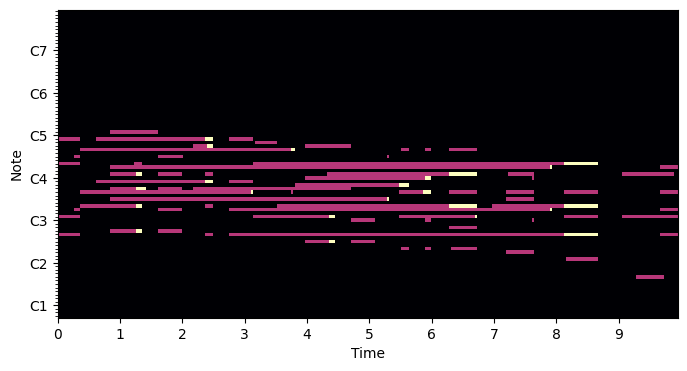

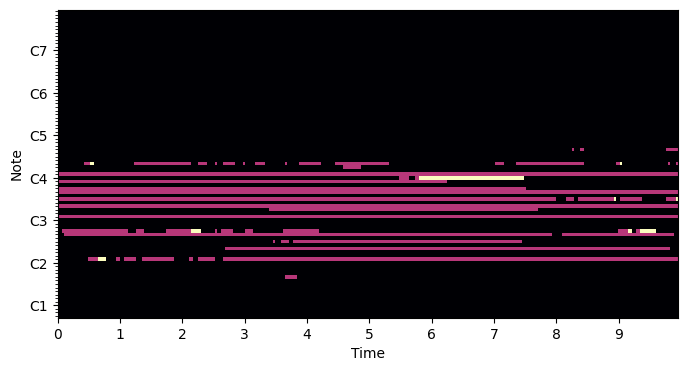

In [ ]:
print(results['pred_midi_path_05'])
def plot_piano_roll(pm, start_pitch, end_pitch, fs=16000):
  """Plot a piano roll of a MIDI file using matplotlib,
  code snippet taken from https://github.com/craffel/pretty-midi/blob/main/Tutorial.ipynb

  Parameters
  ----------
  pm : pretty_midi.PrettyMIDI
    A pretty_midi.PrettyMIDI class instance describing the piano roll.

  start_pitch : int
    The lowest pitch to plot.

  end_pitch : int
    The highest pitch to plot.

  fs : int
    The sampling rate of the audio.

  """
  plt.figure(figsize=(8, 4))
  # Use librosa's specshow function for displaying the piano roll
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                            hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                            fmin=pretty_midi.note_number_to_hz(start_pitch))

results['pred_midi_path_05']
pm = pretty_midi.PrettyMIDI(str(results['true_midi_path']))
plot_piano_roll(pm, 21, 108)

pm = pretty_midi.PrettyMIDI(str(results['pred_midi_path_05']))
plot_piano_roll(pm,21,108)

In [ ]:
pos_weight = torch.tensor(17.3646)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
test_loss, test_error = evaluate(model_loaded_from_drive, test_loader, criterion)
print(f"Test Accuracy: {1-test_error:.4f}")

Test Accuracy: 0.8252
